In [3]:
# import
import pandas as pd
import numpy as np
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score, precision_score, recall_score, log_loss

import matplotlib.pyplot as plt
import os
import csv
import mplcursors

import lightgbm as lgb
from sklearn.model_selection import KFold
from tqdm import tqdm

# Define paths
DATA_PATH = 'data/'
OUTPUT_PATH = 'log/'

In [4]:
# prepare data - stylus: train / val / test
feature_df = pd.read_csv(DATA_PATH + 'feature_df_231227.csv')
feature_df.dropna(axis=0,inplace=True)
train_label_set = pd.read_csv(DATA_PATH + 'train_label_set.csv', usecols=['student_id', 'is_PHQ-9'])
validation_label_set = pd.read_csv(DATA_PATH + 'test_label_set.csv', usecols=['student_id', 'is_PHQ-9'])

train_set = pd.merge(feature_df, train_label_set, on='student_id', how='inner')
train_set.drop(['student_id','quiz_id','week_id','try_id','device_os'], axis=1, inplace=True)
X = train_set.copy()
X.drop(['is_PHQ-9'], axis=1, inplace=True)
y = train_set['is_PHQ-9']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

test_set = pd.merge(feature_df, validation_label_set, on='student_id', how='inner')
test_set.drop(['student_id','quiz_id','week_id','try_id','device_os'], axis=1, inplace=True)
X_test = test_set.copy()
X_test.drop(['is_PHQ-9'], axis=1, inplace=True)
y_test = test_set['is_PHQ-9']

In [17]:
# prepare data - stylus: train / test
feature_df = pd.read_csv(DATA_PATH + 'feature_df_231227.csv')
feature_df.dropna(axis=0,inplace=True)
train_label_set = pd.read_csv(DATA_PATH + 'train_label_set.csv', usecols=['student_id', 'is_PHQ-9'])
validation_label_set = pd.read_csv(DATA_PATH + 'test_label_set.csv', usecols=['student_id', 'is_PHQ-9'])

train_set = pd.merge(feature_df, train_label_set, on='student_id', how='inner')
train_set.drop(['student_id','quiz_id','week_id','try_id','device_os'], axis=1, inplace=True)
X_train = train_set.copy()
X_train.drop(['is_PHQ-9'], axis=1, inplace=True)
y_train = train_set['is_PHQ-9']

test_set = pd.merge(feature_df, validation_label_set, on='student_id', how='inner')
test_set.drop(['student_id','quiz_id','week_id','try_id','device_os'], axis=1, inplace=True)
X_test = test_set.copy()
X_test.drop(['is_PHQ-9'], axis=1, inplace=True)
y_test = test_set['is_PHQ-9']

In [18]:
print(X_train.columns)
print(X_train.shape)
X_train.head()

Index(['num_stroke', 'num_stroke_per_sec', 'x_speed_mean', 'x_speed_std',
       'x_abs_speed_mean', 'x_abs_speed_std', 'y_speed_mean', 'y_speed_std',
       'y_abs_speed_mean', 'y_abs_speed_std', 'speed_mean', 'speed_std',
       'x_speed_skew', 'x_speed_kur', 'x_abs_speed_skew', 'x_abs_speed_kur',
       'y_speed_skew', 'y_speed_kur', 'y_abs_speed_skew', 'y_abs_speed_kur',
       'speed_skew', 'speed_kur', 'x_acc_mean', 'x_acc_std', 'x_abs_acc_mean',
       'x_abs_acc_std', 'y_acc_mean', 'y_acc_std', 'y_abs_acc_mean',
       'y_abs_acc_std', 'acc_mean', 'acc_std', 'length_mean', 'length_std',
       'length_skew', 'length_kur', 'time_mean', 'time_std',
       'ratio_writing_time', 'displacement_mean', 'displacement_std',
       'direction_mean', 'direction_std', 'stroke_interval_mean',
       'stroke_interval_std', 'x_speed_on_mean', 'x_speed_on_std',
       'x_speed_on_skew', 'x_speed_on_kur', 'y_speed_on_mean',
       'y_speed_on_std', 'y_speed_on_skew', 'y_speed_on_kur', 'speed_on

num_stroke  num_stroke_per_sec  x_speed_mean  x_speed_std  \
0          29            1.861839      0.034251     0.091362   
1           9            0.336474     -0.005696     0.196781   
2          59            0.705607      0.026169     0.117813   
3          21            1.298220      0.043748     0.118639   
4          10            0.161228     -0.025706     0.121728   

   x_abs_speed_mean  x_abs_speed_std  y_speed_mean  y_speed_std  \
0          0.077351         0.058817      0.019153     0.096751   
1          0.119719         0.153562     -0.013100     0.127558   
2          0.059865         0.104709      0.020417     0.106994   
3          0.094045         0.083631      0.004604     0.107954   
4          0.088494         0.085724      0.111279     0.365496   

   y_abs_speed_mean  y_abs_speed_std  ...    x_skew     x_kur    y_mean  \
0          0.072013         0.066812  ...  0.370418  8.446922  0.271631   
1          0.100771         0.075503  ... -0.184354 -2.064585  0.453289   
2          0.065821         0.086657  ... -2.223459  4.779686  0.187751   
3          0.087601         0.061928  ... -0.983447  2.176991  0.352393   
4          0.272584         0.262847  ... -1.258650  1.844374  0.471575   

      y_std    y_skew     y_kur     width    height     ratio      area  
0  0.081513  2.093513  4.411383  0.550781  0.362500  1.519397  0.199658  
1  0.067194  0.232881 -1.580067  0.451562  0.186328  2.423480  0.084139  
2  0.088593  2.991959  9.469642  0.646484  0.465234  1.389589  0.300767  
3  0.161981  0.354406 -1.933265  0.673047  0.361719  1.860691  0.243454  
4  0.073180 -0.077694 -1.447609  0.773047  0.220703  3.502655  0.170614  

[5 rows x 93 columns]

In [19]:
print(y_train.shape)
y_train.head()

(32910,)


0    0
1    0
2    0
3    0
4    0
Name: is_PHQ-9, dtype: int64

In [20]:
print(X_test.columns)
print(X_test.shape)
X_test.head()

Index(['num_stroke', 'num_stroke_per_sec', 'x_speed_mean', 'x_speed_std',
       'x_abs_speed_mean', 'x_abs_speed_std', 'y_speed_mean', 'y_speed_std',
       'y_abs_speed_mean', 'y_abs_speed_std', 'speed_mean', 'speed_std',
       'x_speed_skew', 'x_speed_kur', 'x_abs_speed_skew', 'x_abs_speed_kur',
       'y_speed_skew', 'y_speed_kur', 'y_abs_speed_skew', 'y_abs_speed_kur',
       'speed_skew', 'speed_kur', 'x_acc_mean', 'x_acc_std', 'x_abs_acc_mean',
       'x_abs_acc_std', 'y_acc_mean', 'y_acc_std', 'y_abs_acc_mean',
       'y_abs_acc_std', 'acc_mean', 'acc_std', 'length_mean', 'length_std',
       'length_skew', 'length_kur', 'time_mean', 'time_std',
       'ratio_writing_time', 'displacement_mean', 'displacement_std',
       'direction_mean', 'direction_std', 'stroke_interval_mean',
       'stroke_interval_std', 'x_speed_on_mean', 'x_speed_on_std',
       'x_speed_on_skew', 'x_speed_on_kur', 'y_speed_on_mean',
       'y_speed_on_std', 'y_speed_on_skew', 'y_speed_on_kur', 'speed_on

num_stroke  num_stroke_per_sec  x_speed_mean  x_speed_std  \
0          10            1.089206      0.030976     0.169588   
1          17            0.494244      0.038395     0.137033   
2          87            0.925404      0.051187     0.219932   
3          18            1.681143      0.041977     0.238343   
4         185            1.359355      0.027167     0.128357   

   x_abs_speed_mean  x_abs_speed_std  y_speed_mean  y_speed_std  \
0          0.136627         0.101043      0.011509     0.192568   
1          0.094511         0.105469      0.020992     0.077977   
2          0.111673         0.196154      0.032378     0.180070   
3          0.177647         0.162368      0.061307     0.162092   
4          0.077552         0.105774      0.013592     0.127508   

   y_abs_speed_mean  y_abs_speed_std  ...    x_skew      x_kur    y_mean  \
0          0.144250         0.124186  ...  2.138827   4.155366  0.348743   
1          0.064409         0.047696  ... -0.264532  -1.800297  0.349043   
2          0.104592         0.149970  ...  0.958938   0.786093  0.258673   
3          0.131033         0.112121  ...  2.929237  11.065903  0.360620   
4          0.084146         0.096685  ...  0.599702  -0.276829  0.287230   

      y_std    y_skew     y_kur     width    height     ratio      area  
0  0.103748  0.264292 -1.099672  0.500781  0.330078  1.517160  0.165297  
1  0.175497  0.254980 -1.988372  0.398047  0.394141  1.009911  0.156886  
2  0.083523  0.490145  2.225394  0.907813  0.536719  1.691412  0.487240  
3  0.145804  0.261309 -1.766598  0.536719  0.380078  1.412127  0.203995  
4  0.107569 -0.282439  0.906869  0.835547  0.527734  1.583272  0.440947  

[5 rows x 93 columns]

In [ ]:
# not used in param selection, but used in feature selection
# to get metric value for param selection, use 'get_metric_for_param_search'

def get_metric(X_val, y_val, X_test, y_test, feature_subset, lgbm_models, feature_importance_df, column_index_mapping, object):
    if isinstance(X_val, pd.DataFrame):
        feature_subset = list(feature_subset)

    inner_threshold = 0.5 # for prob
    threshold = 1         # for vote
    
    ############################################################ to derive metric value in test set
    
    y_val_true_total = y_val
    y_val_pred_proba_total = np.zeros((len(y_val), 5))
    
    for i, model in enumerate(lgbm_models):
        y_val_pred_proba = model.predict(X_val)

        y_val_pred_proba_total[:, i] = y_val_pred_proba
        # print(model.feature_importance())
        feature_importance_df[f'fold_{i}'] = model.feature_importance()
        # feature_importance_df[f'fold_{i}'] = pd.Series(model.feature_importance(), index=feature_importance_df.index)
        
    feature_importance_df.index = [column_index_mapping.get(index) for index in feature_importance_df.index]
    feature_importance_df['mean'] = feature_importance_df.mean(axis=1)
    # feature_importance_df['index'] = feature_subset
    feature_importance_df['normalised'] = feature_importance_df['mean'] / feature_importance_df['mean'].sum()
    # df_reset = feature_importance_df.reset_index()
    feature_importance_dict = pd.Series(feature_importance_df['normalised'].values, index=feature_importance_df.index).to_dict()
                                            
    y_val_pred_total = np.where(y_val_pred_proba_total > inner_threshold, 1, 0)
    y_val_final_proba = y_val_pred_proba_total.mean(axis=1)
    y_val_final_pred = y_val_pred_total.sum(axis=1)
    y_val_group_pred = np.where(y_val_final_pred > threshold, 1, 0)
    
    acc_val = accuracy_score(y_val_true_total, y_val_group_pred)
    pre_val = precision_score(y_val_true_total, y_val_group_pred)
    rec_val = recall_score(y_val_true_total, y_val_group_pred)
    # loss_val = log_loss(y_val_true_total, y_val_final_proba)
    f1_val = f1_score(y_val_true_total, y_val_group_pred)
    auc_val = roc_auc_score(y_val_true_total, y_val_final_proba)
    
    ############################################################ to derive metric value in validation set

    y_test_true_total = y_test
    y_test_pred_proba_total = np.zeros((len(y_test), 5))
    
    for i, model in enumerate(lgbm_models):
        y_test_pred_proba = model.predict(X_test)

        y_test_pred_proba_total[:, i] = y_test_pred_proba
                                            
    y_test_pred_total = np.where(y_test_pred_proba_total > inner_threshold, 1, 0)
    y_test_final_proba = y_test_pred_proba_total.mean(axis=1)
    y_test_final_pred = y_test_pred_total.sum(axis=1)
    y_test_group_pred = np.where(y_test_final_pred > threshold, 1, 0)
    
    acc_test = accuracy_score(y_test_true_total, y_test_group_pred)
    pre_test = precision_score(y_test_true_total, y_test_group_pred)
    rec_test = recall_score(y_test_true_total, y_test_group_pred)
    # loss_test = log_loss(y_test_true_total, y_test_final_proba)
    f1_test = f1_score(y_test_true_total, y_test_group_pred)
    auc_test = roc_auc_score(y_test_true_total, y_test_group_pred)
    
    ############################################################
    
    if object == 'acc':
        return acc_val,acc_test,pre_test,rec_test,f1_test,auc_test,feature_importance_dict
    elif object == 'pre':
        return pre_val,acc_test,pre_test,rec_test,f1_test,auc_test,feature_importance_dict
    elif object == 'rec':
        return rec_val,acc_test,pre_test,rec_test,f1_test,auc_test,feature_importance_dict
    elif object == 'f1':
        return f1_val,acc_test,pre_test,rec_test,f1_test,auc_test,feature_importance_dict
    elif object == 'auc':
        return auc_val,acc_test,pre_test,rec_test,f1_test,auc_test,feature_importance_dict

In [21]:
# record each case (parameter set / acc / metric)

def record_on_csv(acc_test,pre_test,rec_test,f1_test,auc_test,params,file_gen_time): # file name format: 'param_select_{file_gen_time}.csv'
    path = 'log/param_selection'
    file_path = f'{path}/param_select_{file_gen_time}.csv'

    row_to_add = [acc_test,pre_test,rec_test,f1_test,auc_test,
                  params[0],params[1],params[2],params[3],params[4],params[5],params[6],
                  params[7],params[8],params[9],params[10],params[11],params[12],params[13]]

    # Check if file exists
    file_exists = os.path.exists(file_path)

    # Open the file in append mode if it exists, or write mode if it doesn't
    mode = 'a' if file_exists else 'w'

    with open(file_path, mode, newline='') as file:
        writer = csv.writer(file)
        
        # If the file is being created, you might want to write headers here
        if not file_exists:
            headers = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 
                       'objective', 'metric', 'boosting_type', 'learning_rate', 'num_leaves', 'max_depth', 
                       'min_data_in_leaf', 'is_unbalance', 'max_bin', 'verbose', 'random_state', 
                       'num_boost_round', 'inner_threshold', 'threshold']  # Replace with your headers
            writer.writerow(headers)

        # Write the row
        writer.writerow(row_to_add)
    
    return file_path


In [22]:
def plot_from_csv(file_path):
    # Read the CSV file
    data = pd.read_csv(file_path)

    # Ensure the index starts from 1
    data.index = data.index + 1

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(data['Accuracy'], label='Accuracy')
    plt.plot(data['Precision'], label='Precision')
    plt.plot(data['Recall'], label='Recall')
    plt.plot(data['F1 Score'], label='F1 Score')
    plt.plot(data['AUC'], label='AUC')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Values')
    plt.title('Performance Metrics over Epochs')
    plt.legend()

    # Adding cursors
    cursor = mplcursors.cursor(hover=True)
    @cursor.connect("add")
    def on_add(sel):
        x, y = sel.target
        epoch = int(x)
        accuracy = data.at[epoch, 'Accuracy']
        precision = data.at[epoch, 'Precision']
        recall = data.at[epoch, 'Recall']
        f1_score = data.at[epoch, 'F1 Score']
        auc = data.at[epoch, 'AUC']
        sel.annotation.set(text=f'Epoch: {epoch}\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1_score}\nAUC: {auc}')

    plt.show()

In [23]:
# get_metric_for_param_search
# function to get metric in param selection

def get_metric_for_param_search(X_test, y_test, lgbm_models):

    inner_threshold = 0.5 # for prob
    threshold = 1         # for vote
    
    ############################################################ to derive metric value in test set

    y_test_true_total = y_test
    y_test_pred_proba_total = np.zeros((len(y_test), 5))
    
    for i, model in enumerate(lgbm_models):
        y_test_pred_proba = model.predict(X_test)

        y_test_pred_proba_total[:, i] = y_test_pred_proba
                                            
    y_test_pred_total = np.where(y_test_pred_proba_total > inner_threshold, 1, 0)
    # y_test_final_proba = y_test_pred_proba_total.mean(axis=1)
    y_test_final_pred = y_test_pred_total.sum(axis=1)
    y_test_group_pred = np.where(y_test_final_pred > threshold, 1, 0)
    
    acc_test = accuracy_score(y_test_true_total, y_test_group_pred)
    pre_test = precision_score(y_test_true_total, y_test_group_pred)
    rec_test = recall_score(y_test_true_total, y_test_group_pred)
    # loss_test = log_loss(y_test_true_total, y_test_final_proba)
    f1_test = f1_score(y_test_true_total, y_test_group_pred)
    auc_test = roc_auc_score(y_test_true_total, y_test_group_pred)
    
    ############################################################
    
    return acc_test,pre_test,rec_test,f1_test,auc_test,inner_threshold,threshold 

In [24]:
# define model / set parameter searching loop
# get important features from lightGBM model
def get_model(X_train, y_train, lgb_params, num_boost_round):
    # Specify your configurations as a dict
    models = []

    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    for train_index, val_index in tqdm(kf.split(X_train), desc=f'PHQ-9 - {len(X_train)} samples: '):
        X_train_inner, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_inner, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        lgb_train = lgb.Dataset(X_train_inner, y_train_inner)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

        gbm = lgb.train(lgb_params, lgb_train, num_boost_round=num_boost_round, valid_sets=lgb_eval,)

        models.append(gbm)

    return models

In [25]:
def main(X_train,y_train,X_test,y_test):
    file_gen_time = dt.now().strftime("%Y%m%d_%H%M%S")
    for lr, num_boost_round in zip([0.001, 0.01], [5000, 500]):
        for num_leaves in [255, 1023]:
            for min_data_in_leaf in [5, 10]:
                for max_bin in [255, 1024]:
                    lgb_params = {
                    'objective': 'binary', # fixed
                    'metric': 'binary_logloss', # 'auc' 'binary_error' 
                    'boosting_type': 'gbdt', # 'dart' 'goss'
                    'learning_rate': lr, # 0.01 ~ 0.3
                    'num_leaves': num_leaves, # 64 128 256 512 1024 2048
                    'max_depth': -1, # +1 -1~8
                    'min_data_in_leaf': min_data_in_leaf, # 20 ~ 900
                    'is_unbalance': True, # 'scale_pos_weight'
                    'max_bin': max_bin, # +100 or + 200 255 ~ 1024 
                    'verbose': -1, 
                    'random_state': 1 # 0 or 1
                    }
                    models = get_model(X_train, y_train, lgb_params, num_boost_round)
                    acc_test,pre_test,rec_test,f1_test,auc_test,inner_threshold,threshold = get_metric_for_param_search(X_test, y_test, models)
                    params_in_list = ['binary', 'binary_logloss', 'gbdt', lr, num_leaves, -1, min_data_in_leaf, True, max_bin, -1, 1, num_boost_round,inner_threshold, threshold]
                    csv_file_path = record_on_csv(acc_test,pre_test,rec_test,f1_test,auc_test,params_in_list,file_gen_time)
                    plot_from_csv(csv_file_path)
                    

PHQ-9 - 32910 samples: : 5it [04:18, 51.80s/it]


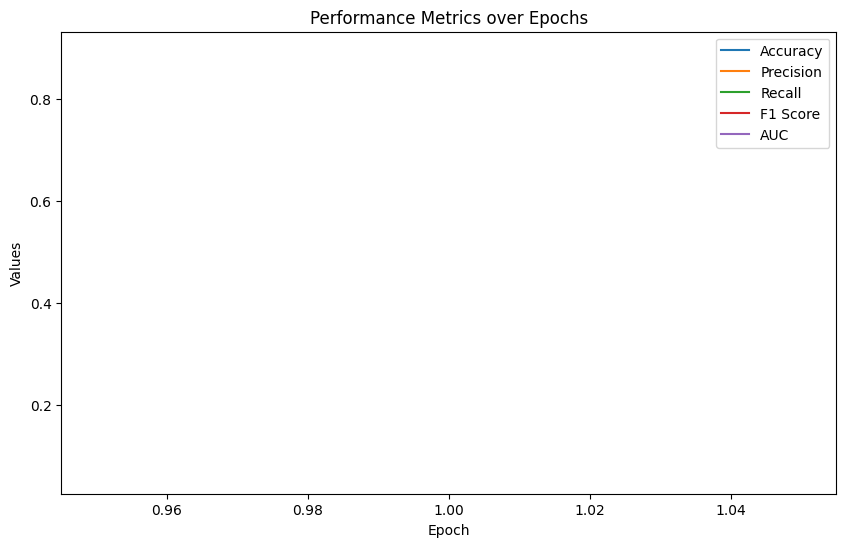

PHQ-9 - 32910 samples: : 5it [12:56, 155.31s/it]


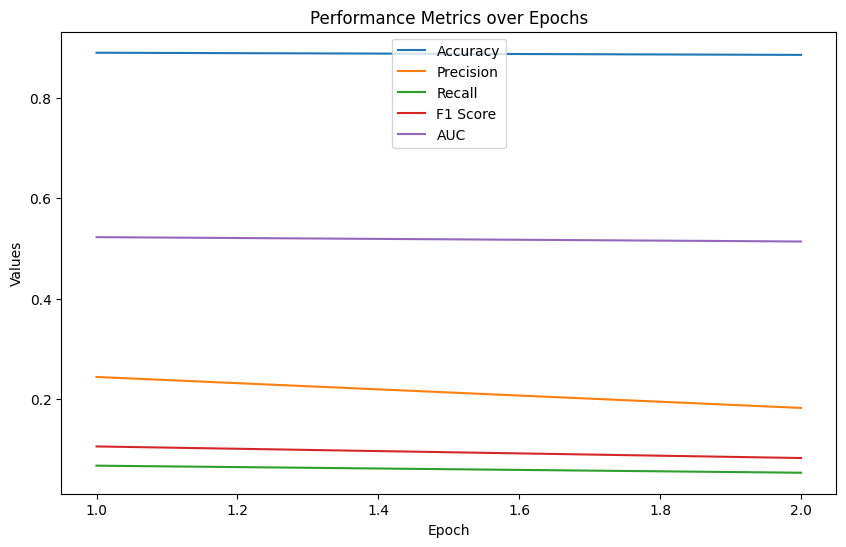

PHQ-9 - 32910 samples: : 5it [04:14, 50.80s/it]


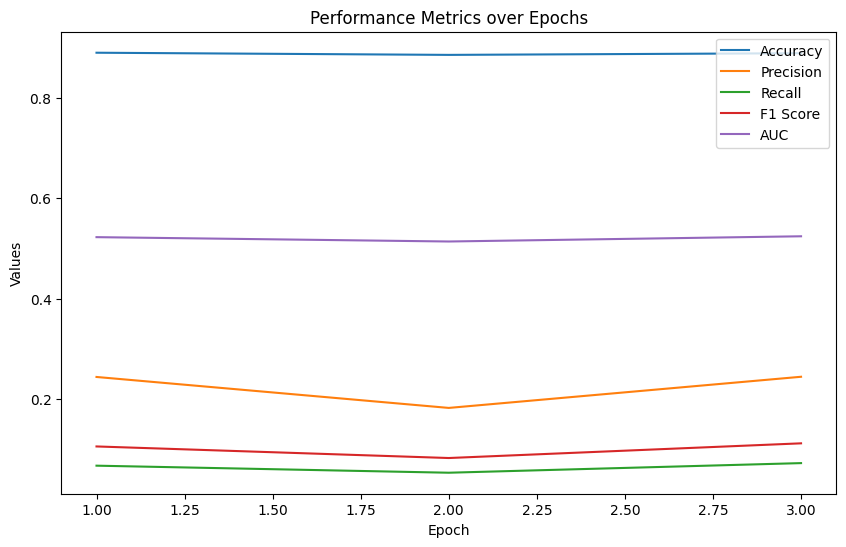

PHQ-9 - 32910 samples: : 5it [19:24, 232.99s/it]


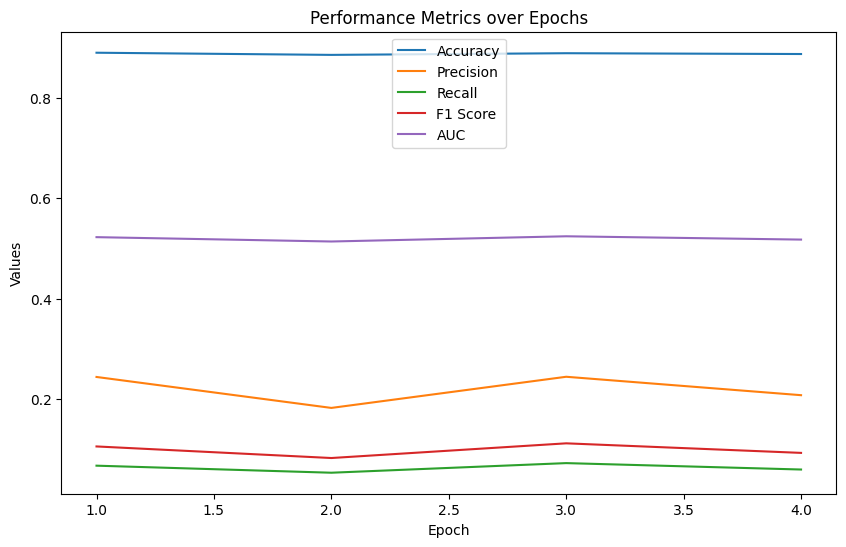

PHQ-9 - 32910 samples: : 5it [1:00:32, 726.43s/it]


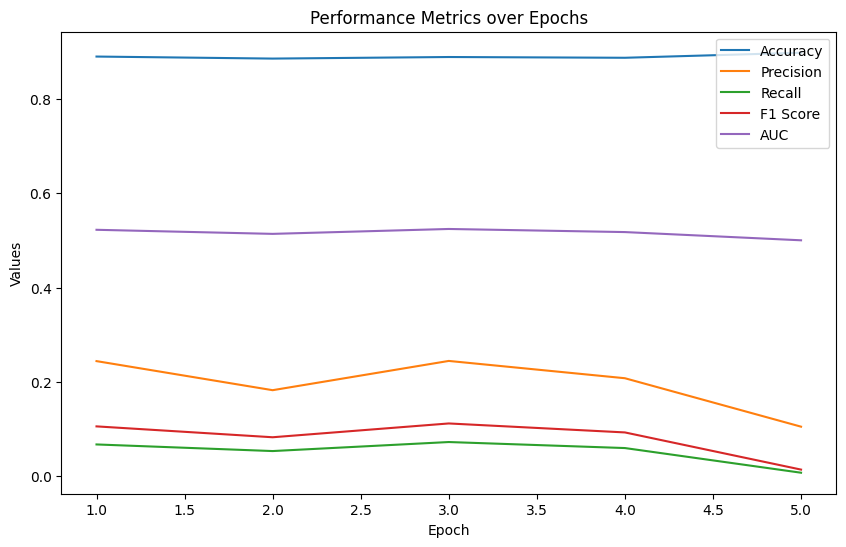

PHQ-9 - 32910 samples: : 5it [1:56:40, 1400.04s/it]


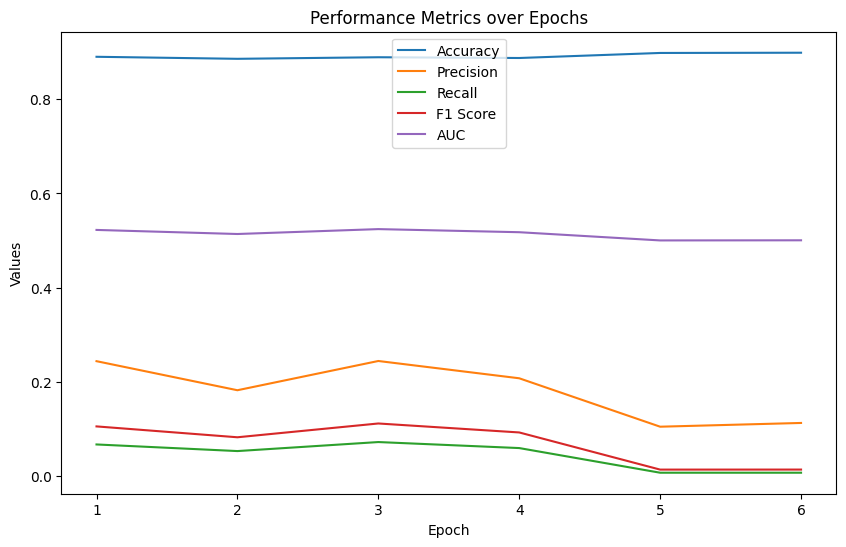

PHQ-9 - 32910 samples: : 5it [59:55, 719.12s/it]


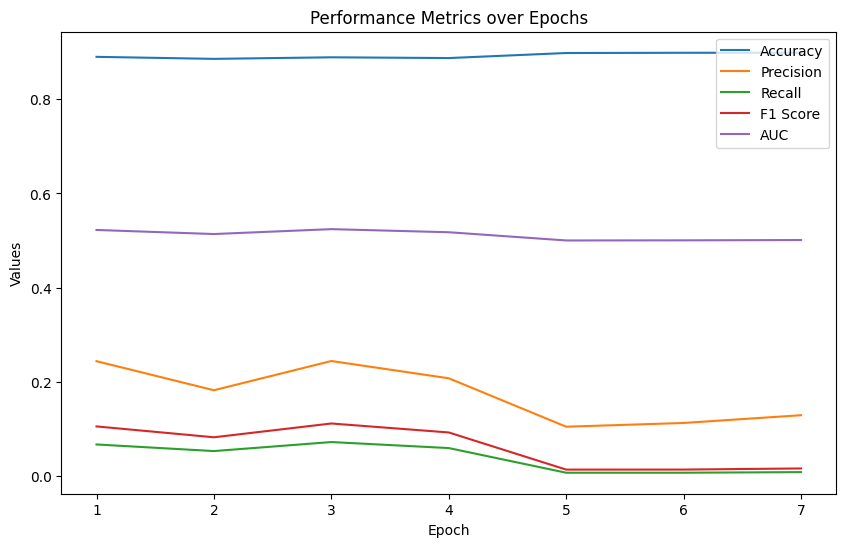

PHQ-9 - 32910 samples: : 5it [1:36:24, 1156.93s/it]


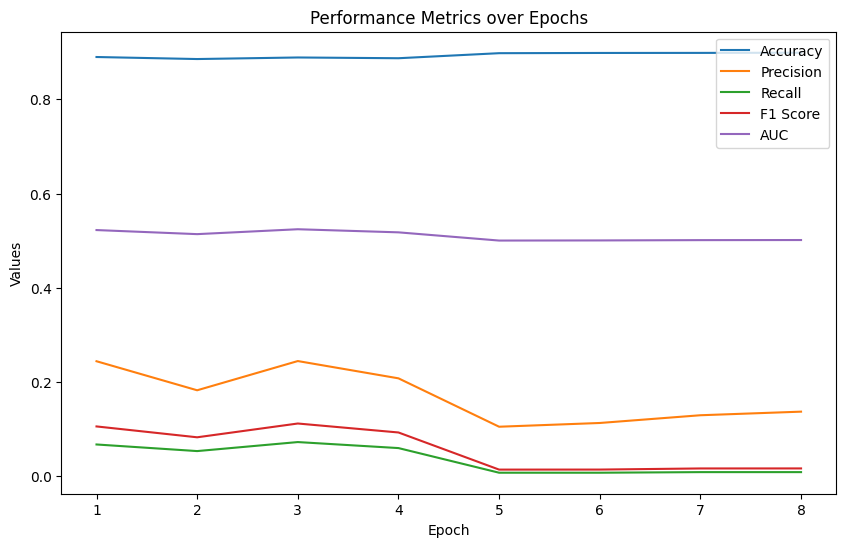

PHQ-9 - 32910 samples: : 5it [00:26,  5.40s/it]


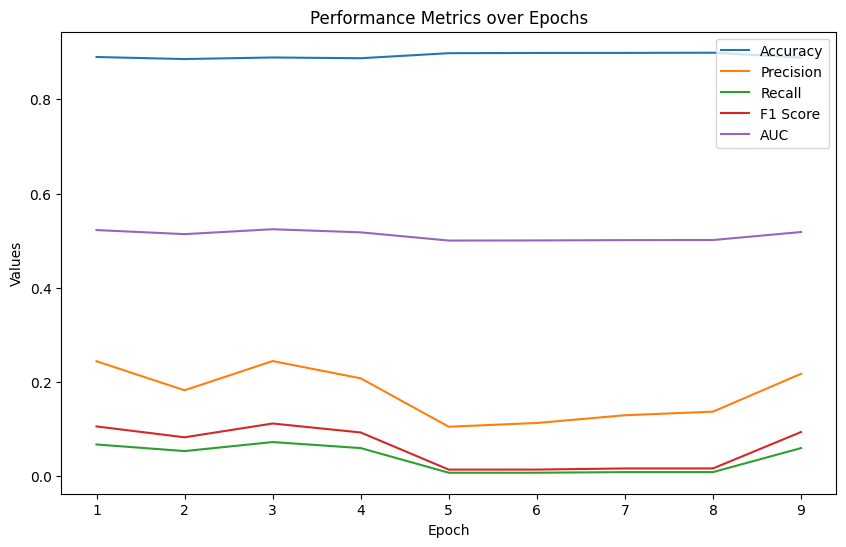

PHQ-9 - 32910 samples: : 5it [01:20, 16.01s/it]


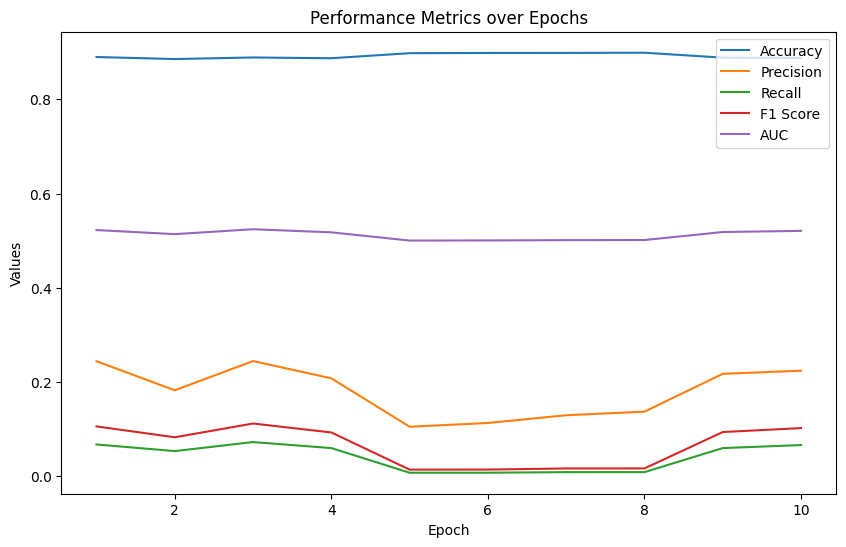

PHQ-9 - 32910 samples: : 5it [00:26,  5.29s/it]


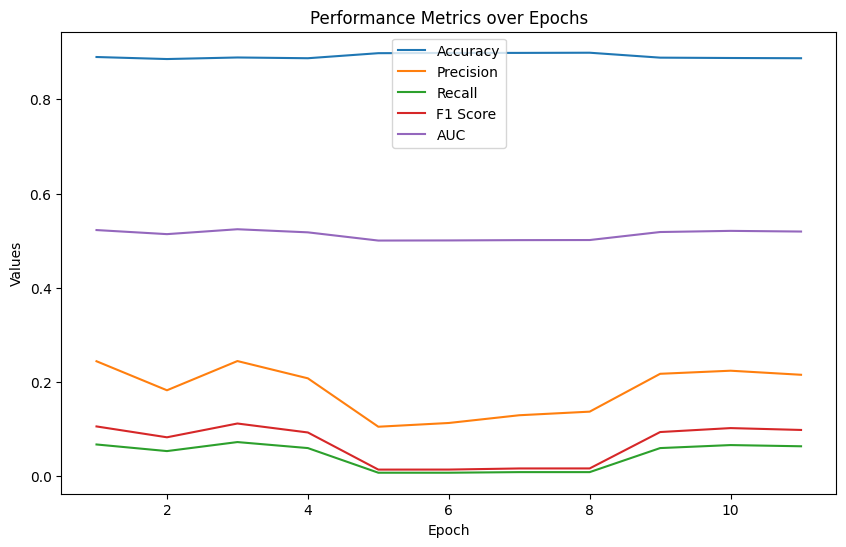

PHQ-9 - 32910 samples: : 5it [01:17, 15.52s/it]


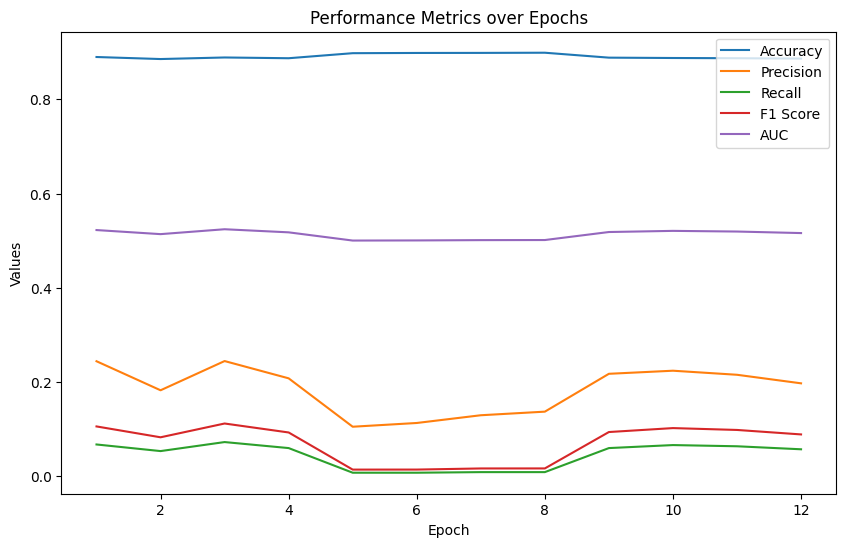

PHQ-9 - 32910 samples: : 5it [01:51, 22.34s/it]


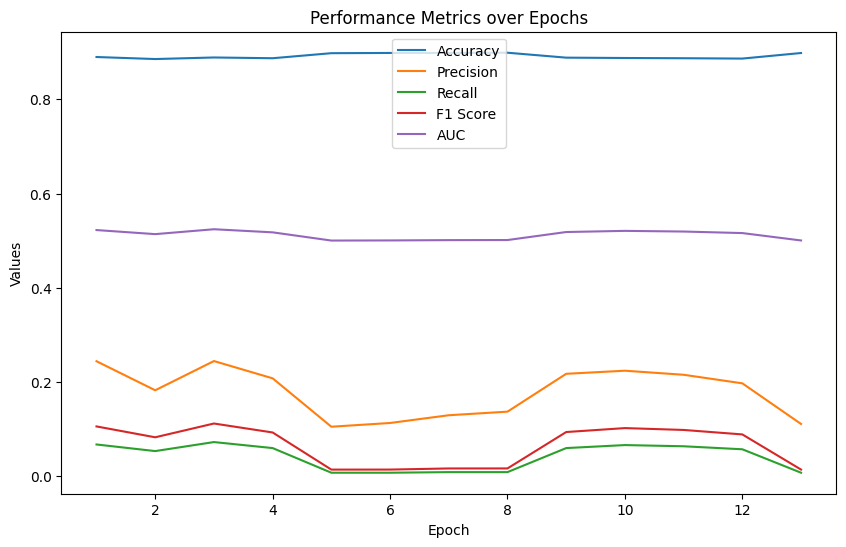

PHQ-9 - 32910 samples: : 5it [05:37, 67.46s/it]


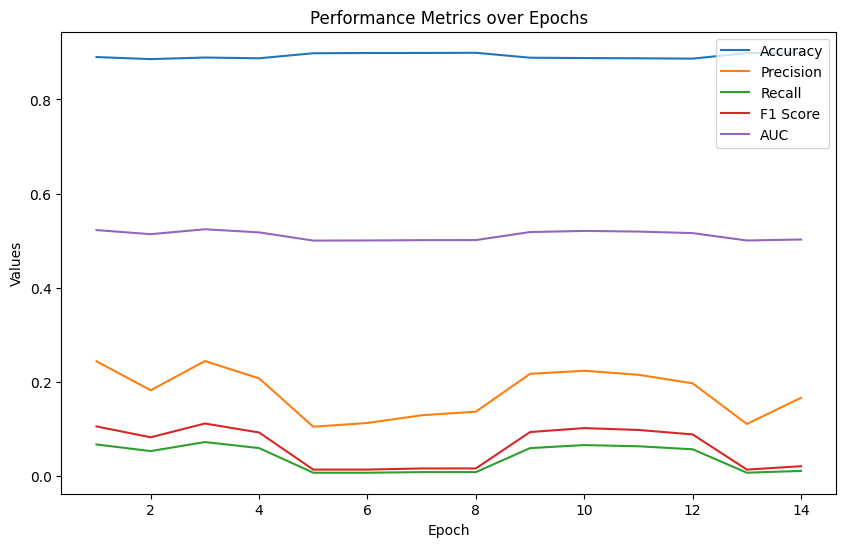

PHQ-9 - 32910 samples: : 5it [01:45, 21.17s/it]


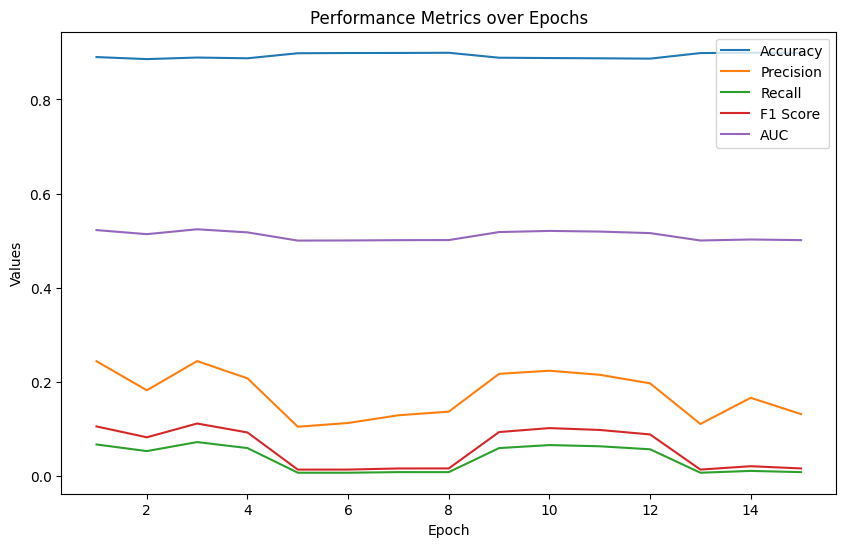

PHQ-9 - 32910 samples: : 5it [05:18, 63.74s/it]


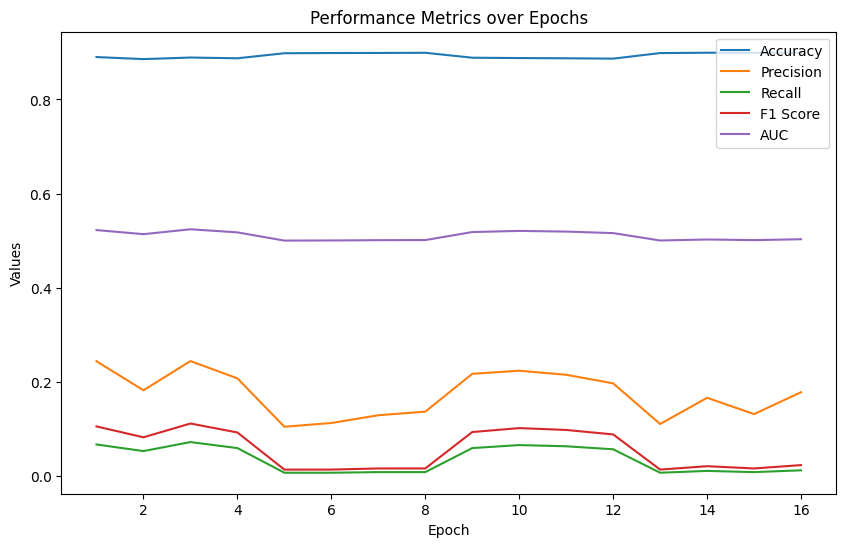

In [27]:
main(X_train,y_train,X_test,y_test)

In [28]:
def main(X_train,y_train,X_test,y_test):
    file_gen_time = dt.now().strftime("%Y%m%d_%H%M%S")
    for lr, num_boost_round in zip([0.001, 0.01], [5000, 500]):
        for num_leaves in [31, 63, 127]:
            for min_data_in_leaf in [5, 10]:
                for max_bin in [255, 1024]:
                    lgb_params = {
                    'objective': 'binary', # fixed
                    'metric': 'binary_logloss', # 'auc' 'binary_error' 
                    'boosting_type': 'gbdt', # 'dart' 'goss'
                    'learning_rate': lr, # 0.01 ~ 0.3
                    'num_leaves': num_leaves, # 64 128 256 512 1024 2048
                    'max_depth': -1, # +1 -1~8
                    'min_data_in_leaf': min_data_in_leaf, # 20 ~ 900
                    'is_unbalance': True, # 'scale_pos_weight'
                    'max_bin': max_bin, # +100 or + 200 255 ~ 1024 
                    'verbose': -1, 
                    'random_state': 1 # 0 or 1
                    }
                    models = get_model(X_train, y_train, lgb_params, num_boost_round)
                    acc_test,pre_test,rec_test,f1_test,auc_test,inner_threshold,threshold = get_metric_for_param_search(X_test, y_test, models)
                    params_in_list = ['binary', 'binary_logloss', 'gbdt', lr, num_leaves, -1, min_data_in_leaf, True, max_bin, -1, 1, num_boost_round,inner_threshold, threshold]
                    csv_file_path = record_on_csv(acc_test,pre_test,rec_test,f1_test,auc_test,params_in_list,file_gen_time)
                    plot_from_csv(csv_file_path)

PHQ-9 - 32910 samples: : 5it [00:38,  7.67s/it]


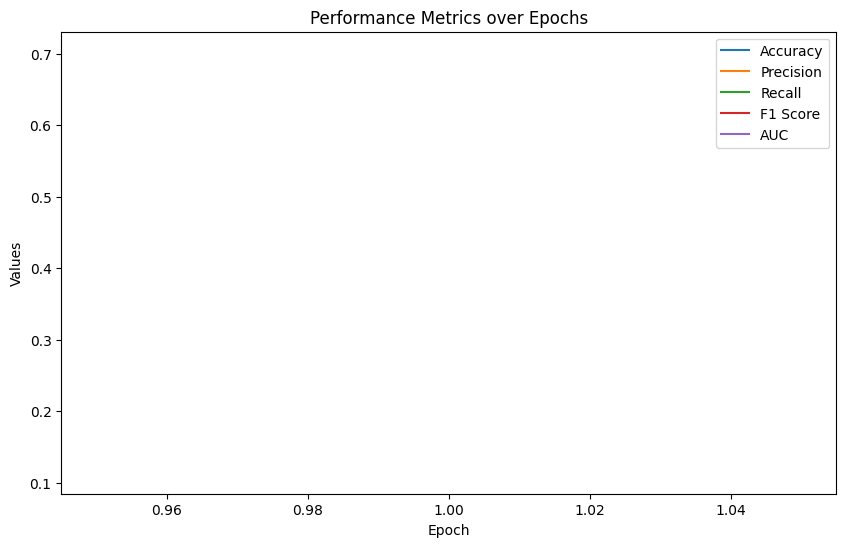

PHQ-9 - 32910 samples: : 5it [01:31, 18.33s/it]


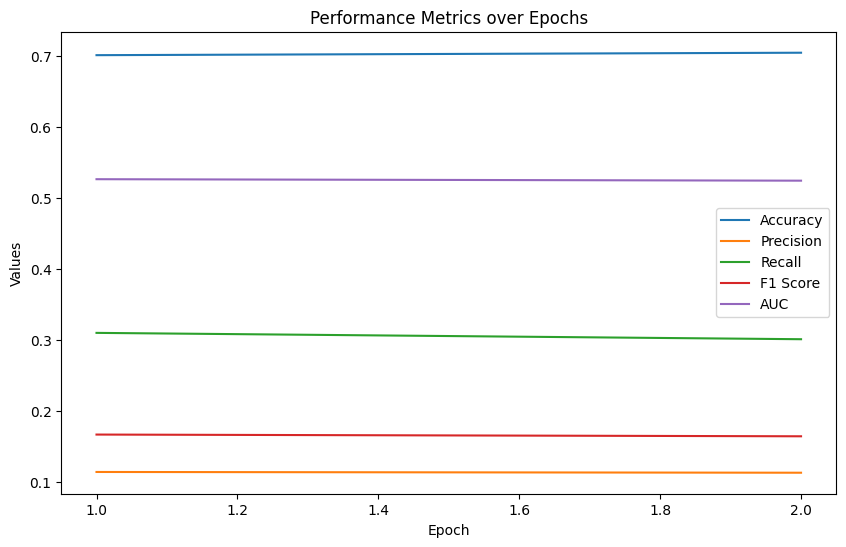

PHQ-9 - 32910 samples: : 5it [00:36,  7.23s/it]


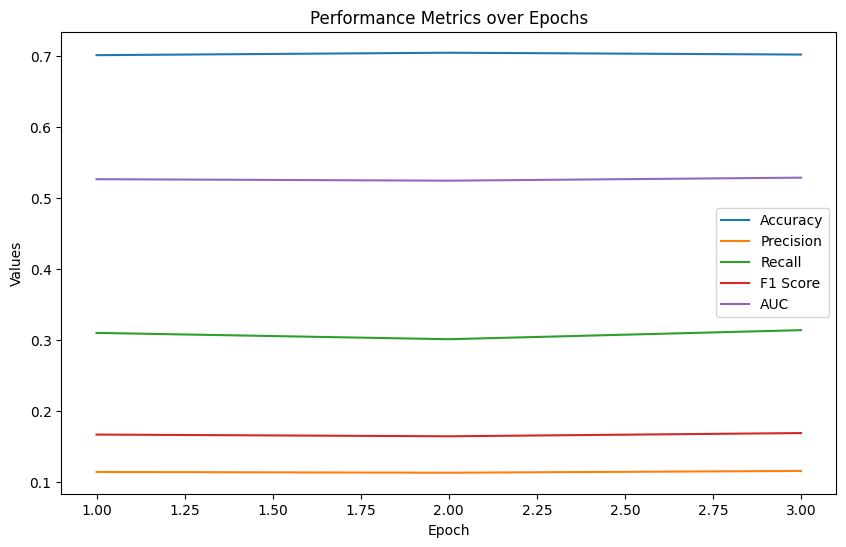

PHQ-9 - 32910 samples: : 5it [01:32, 18.58s/it]


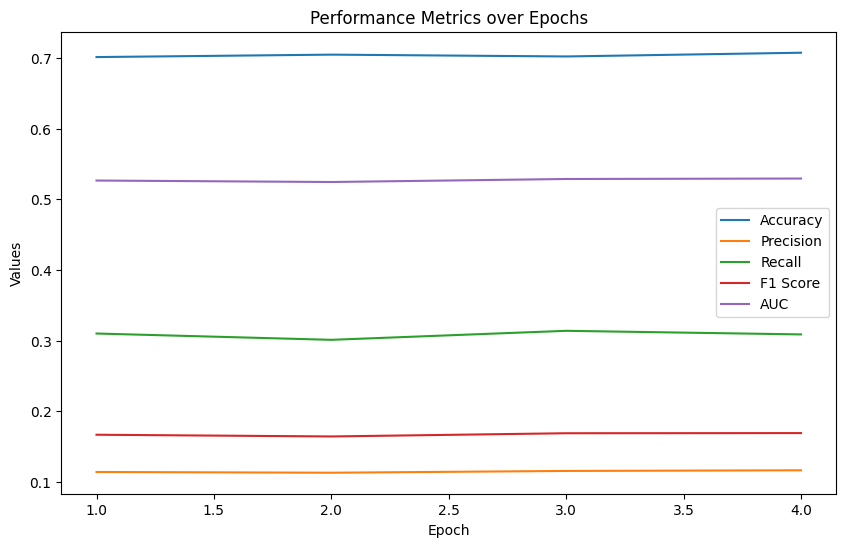

PHQ-9 - 32910 samples: : 5it [01:05, 13.05s/it]


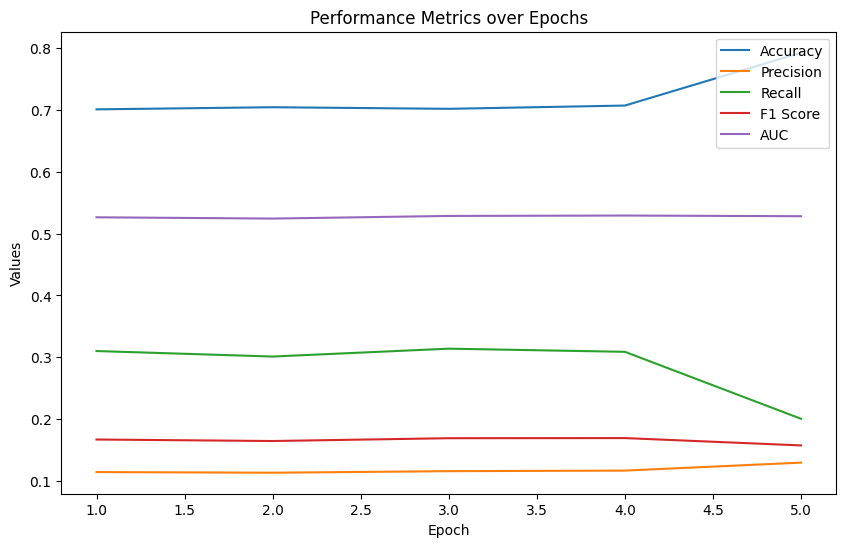

PHQ-9 - 32910 samples: : 5it [03:13, 38.65s/it]


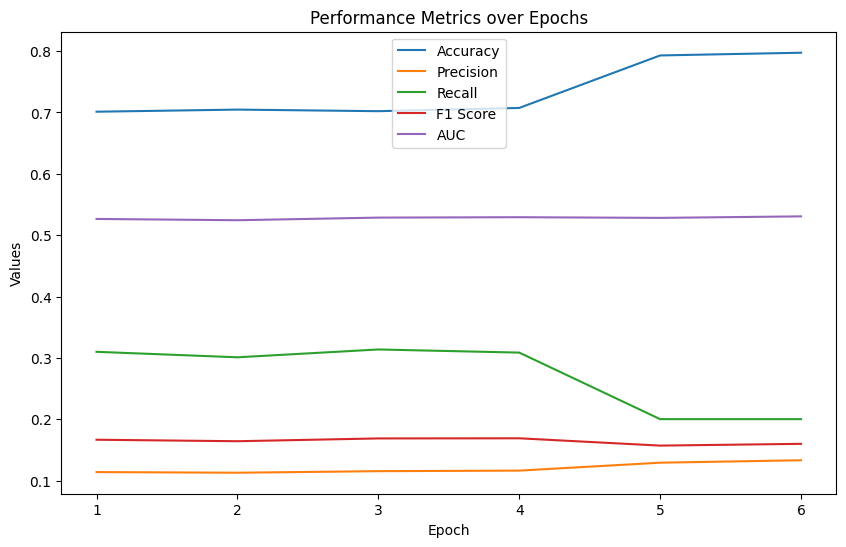

PHQ-9 - 32910 samples: : 5it [01:04, 12.85s/it]


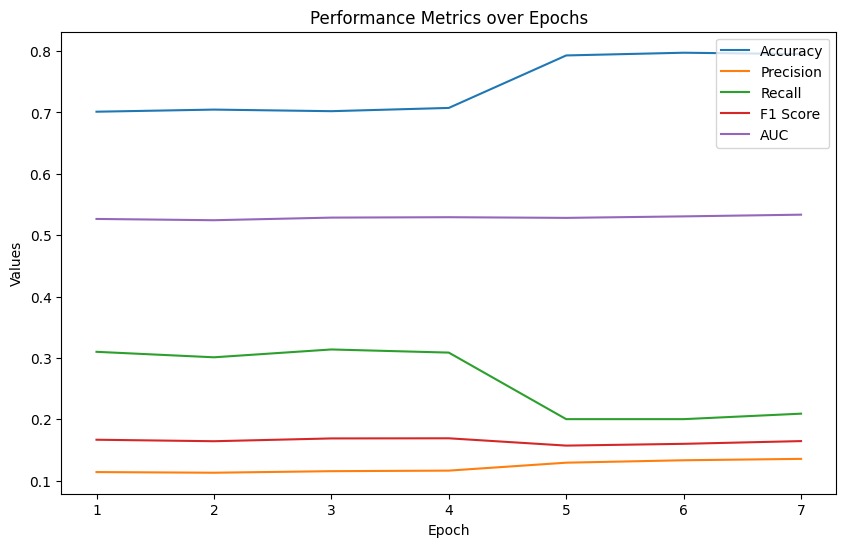

PHQ-9 - 32910 samples: : 5it [03:08, 37.78s/it]


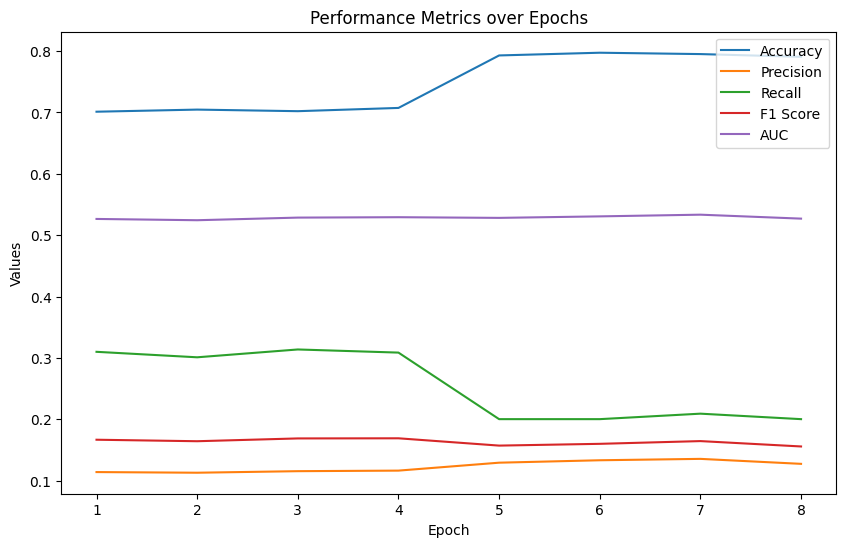

PHQ-9 - 32910 samples: : 5it [02:11, 26.20s/it]


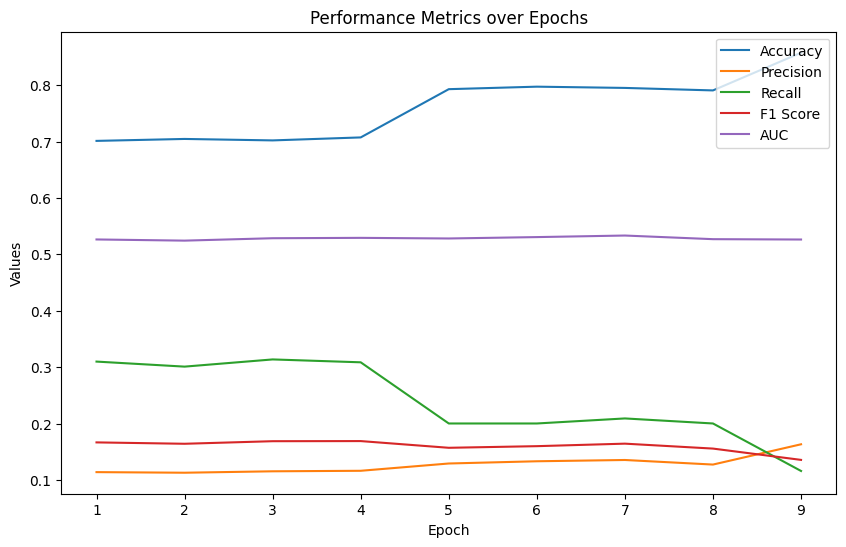

PHQ-9 - 32910 samples: : 5it [06:31, 78.25s/it]


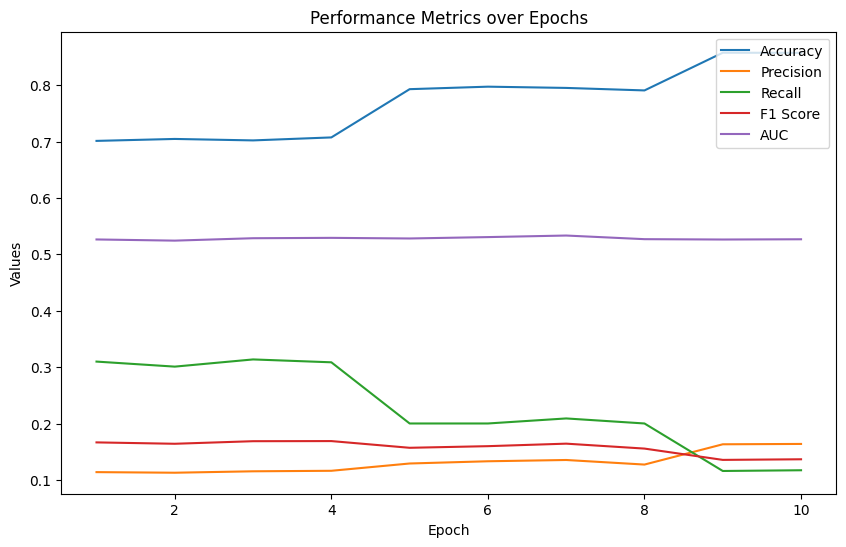

PHQ-9 - 32910 samples: : 5it [02:08, 25.76s/it]


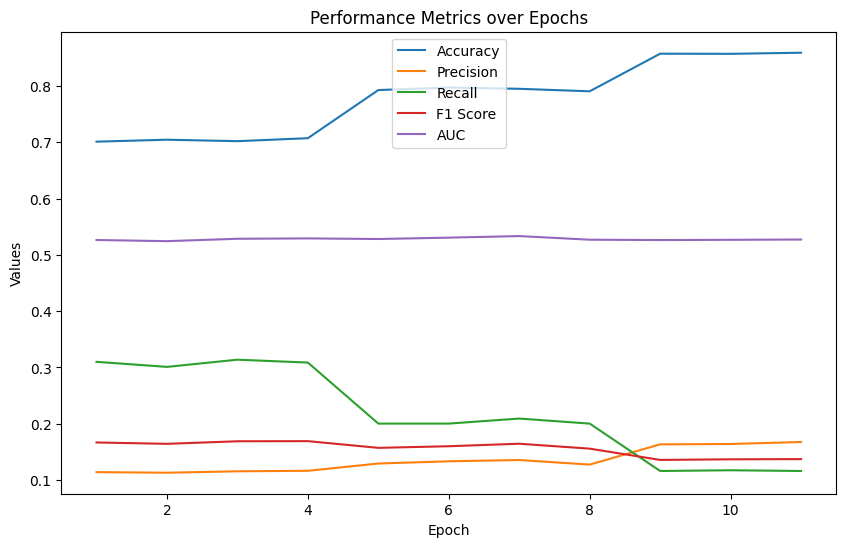

PHQ-9 - 32910 samples: : 5it [06:19, 75.90s/it]


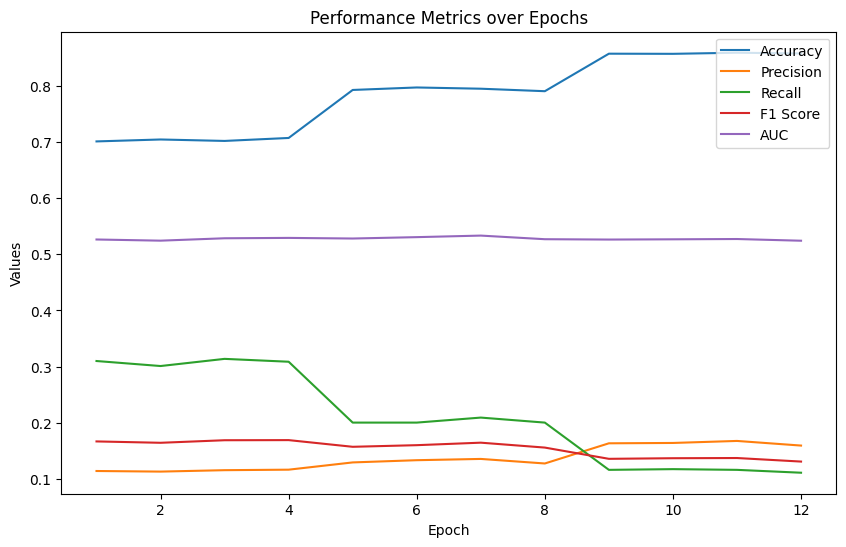

PHQ-9 - 32910 samples: : 5it [00:04,  1.23it/s]


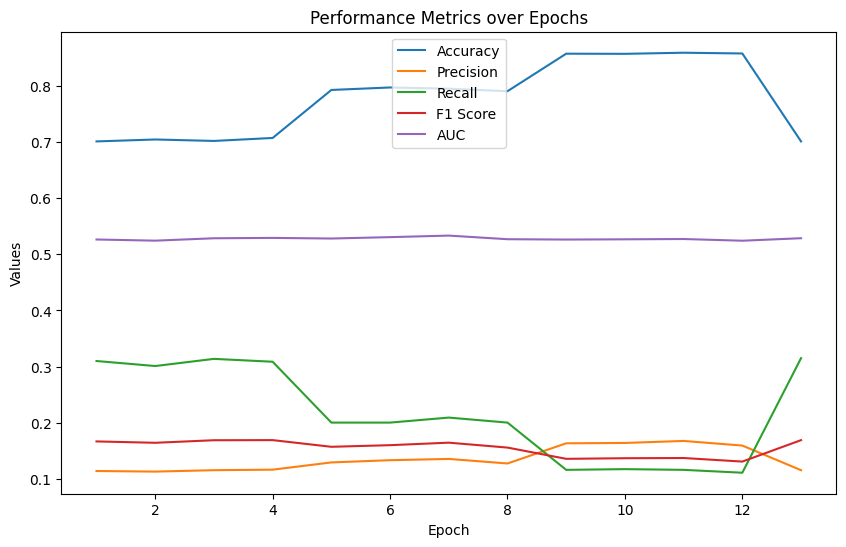

PHQ-9 - 32910 samples: : 5it [00:09,  1.95s/it]


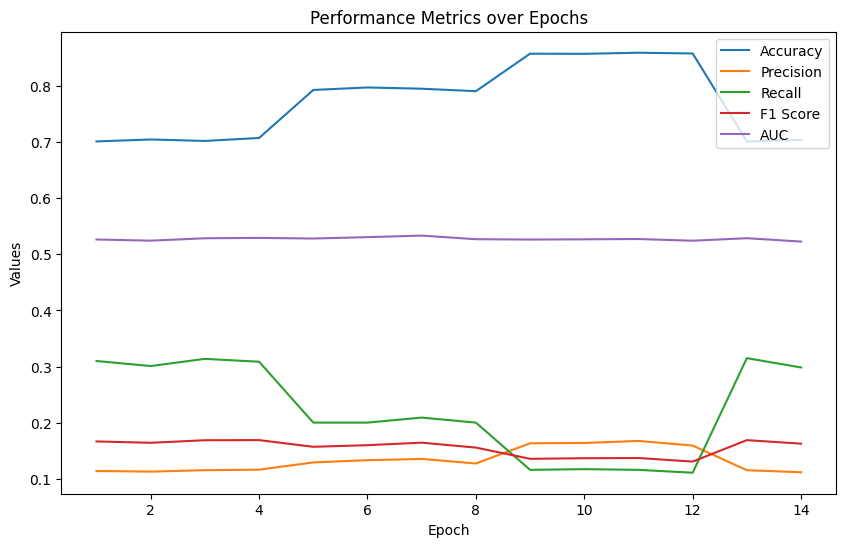

PHQ-9 - 32910 samples: : 5it [00:04,  1.25it/s]


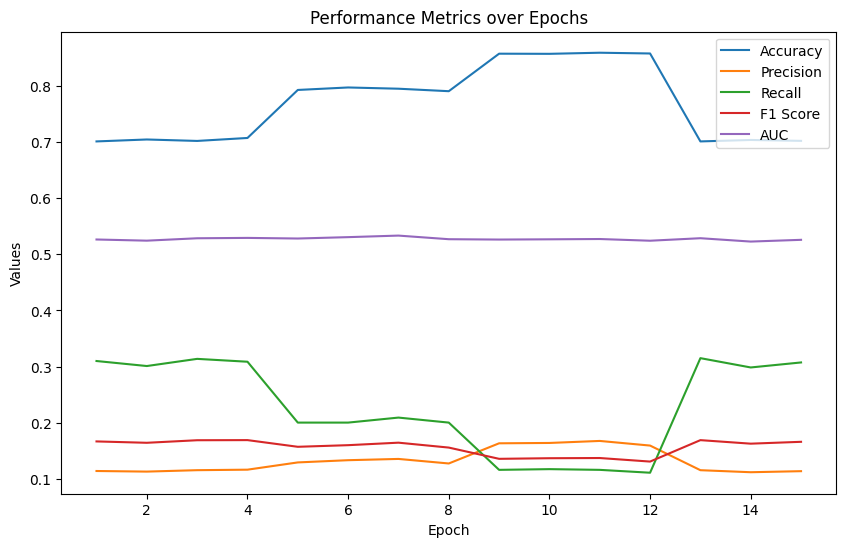

PHQ-9 - 32910 samples: : 5it [00:09,  1.92s/it]


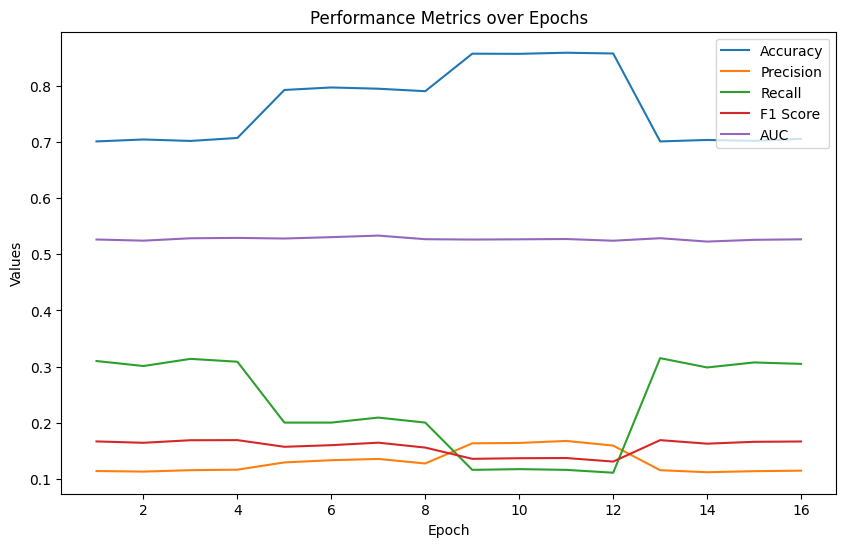

PHQ-9 - 32910 samples: : 5it [00:06,  1.40s/it]


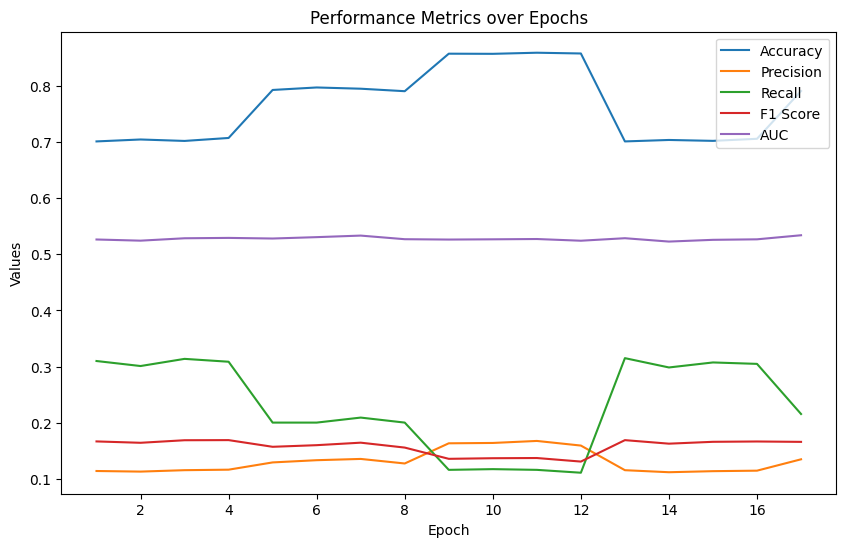

PHQ-9 - 32910 samples: : 5it [00:19,  3.99s/it]


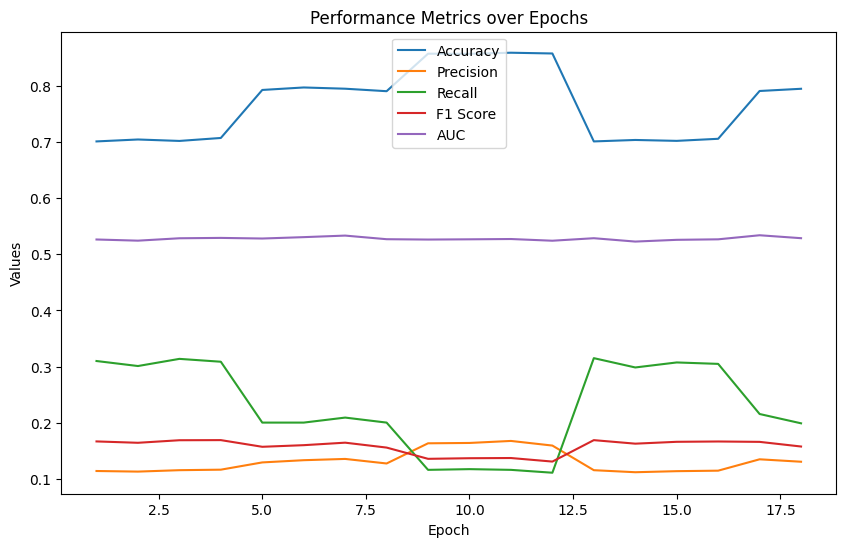

PHQ-9 - 32910 samples: : 5it [00:06,  1.38s/it]


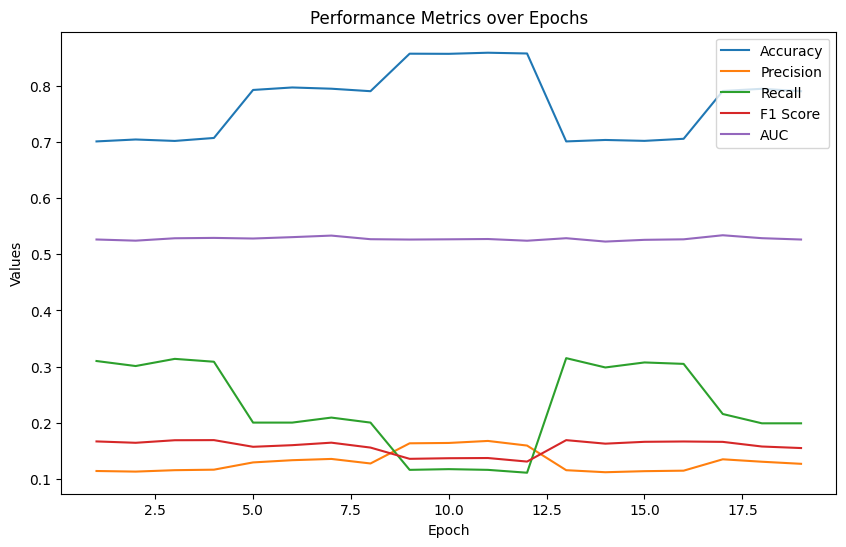

PHQ-9 - 32910 samples: : 5it [00:19,  3.91s/it]


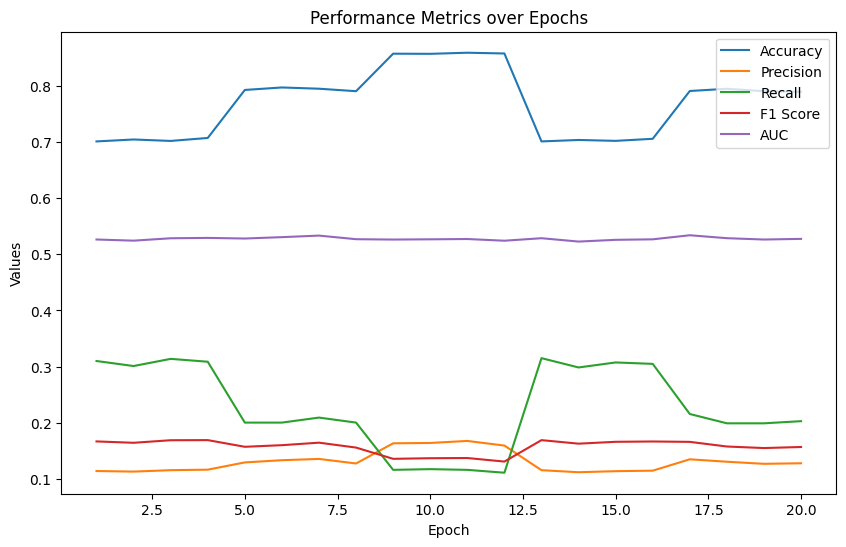

PHQ-9 - 32910 samples: : 5it [00:13,  2.77s/it]


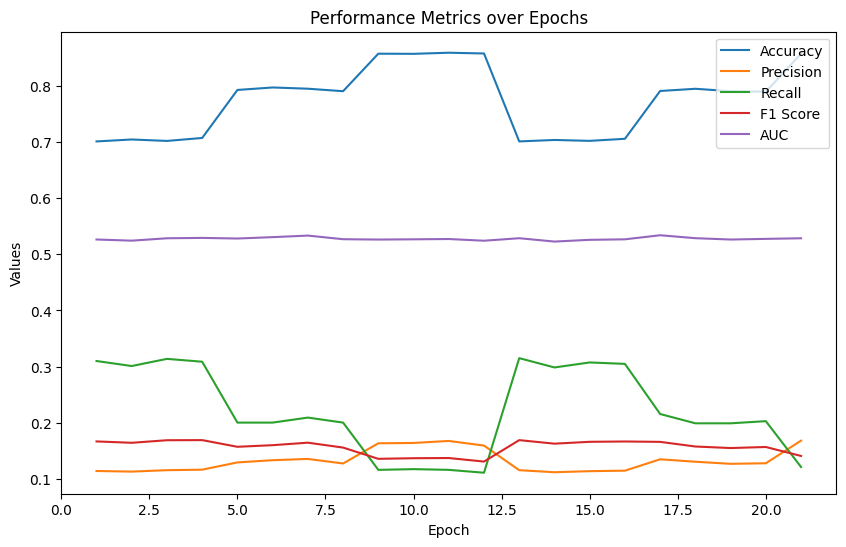

PHQ-9 - 32910 samples: : 5it [00:39,  7.95s/it]


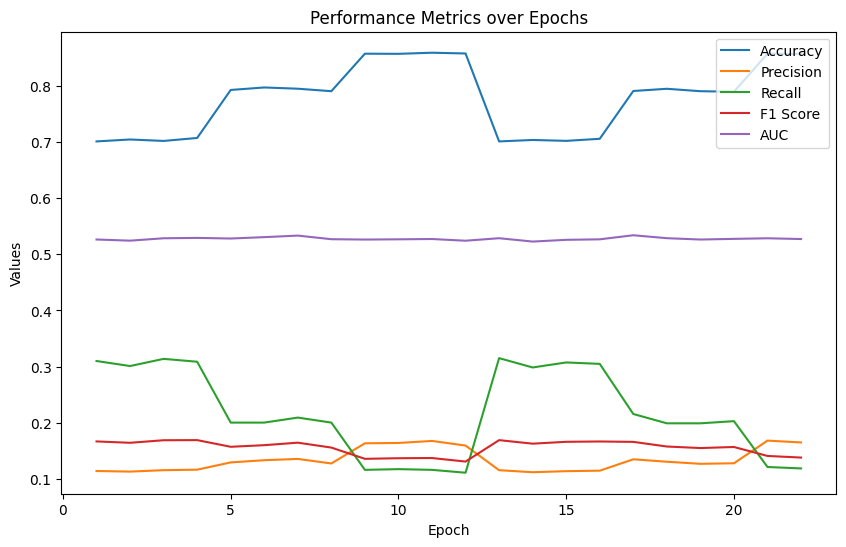

PHQ-9 - 32910 samples: : 5it [00:13,  2.72s/it]


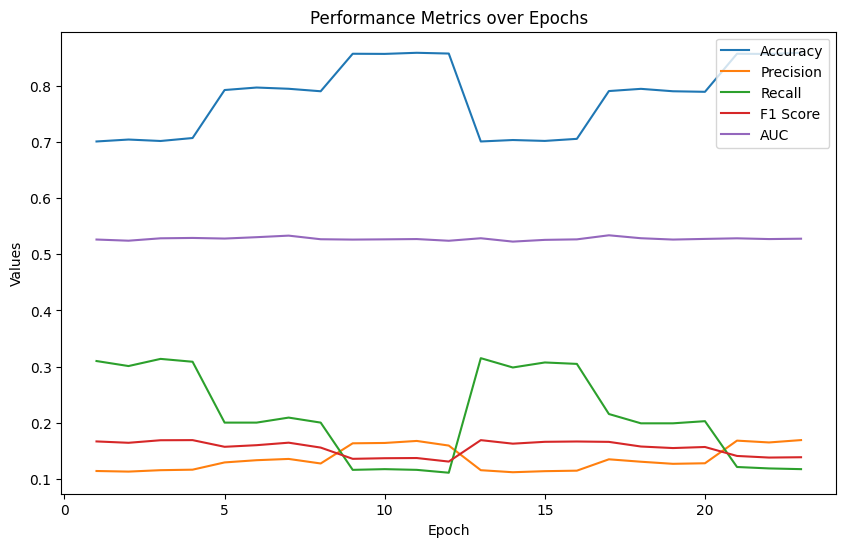

PHQ-9 - 32910 samples: : 5it [00:38,  7.74s/it]


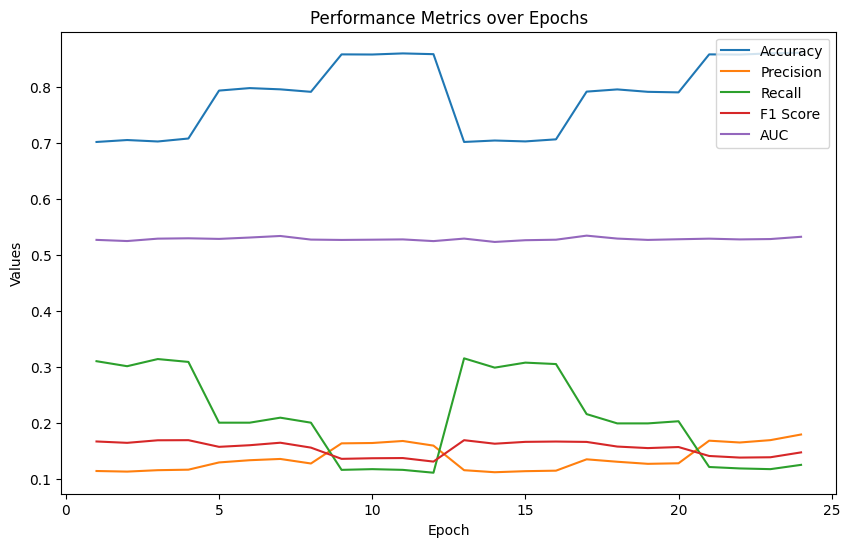

In [29]:
main(X_train,y_train,X_test,y_test)

In [30]:
       
def main(X_train,y_train,X_test,y_test):
    file_gen_time = dt.now().strftime("%Y%m%d_%H%M%S")
    for lr, num_boost_round in zip([0.001, 0.01], [5000, 500]):
        for num_leaves in [31, 64, 128, 256, 512, 1024]:
            for min_data_in_leaf in [5, 10]:
                for max_bin in [31, 63, 127, 255, 511, 1024]:
                    lgb_params = {
                    'objective': 'binary', # fixed
                    'metric': 'binary_logloss', # 'auc' 'binary_error' 
                    'boosting_type': 'gbdt', # 'dart' 'goss'
                    'learning_rate': lr, # 0.01 ~ 0.3
                    'num_leaves': num_leaves, # 64 128 256 512 1024 2048
                    'max_depth': -1, # +1 -1~8
                    'min_data_in_leaf': min_data_in_leaf, # 20 ~ 900
                    'is_unbalance': True, # 'scale_pos_weight'
                    'max_bin': max_bin, # +100 or + 200 255 ~ 1024 
                    'verbose': -1, 
                    'random_state': 1 # 0 or 1
                    }
                    models = get_model(X_train, y_train, lgb_params, num_boost_round)
                    acc_test,pre_test,rec_test,f1_test,auc_test,inner_threshold,threshold = get_metric_for_param_search(X_test, y_test, models)
                    params_in_list = ['binary', 'binary_logloss', 'gbdt', lr, num_leaves, -1, min_data_in_leaf, True, max_bin, -1, 1, num_boost_round,inner_threshold, threshold]
                    csv_file_path = record_on_csv(acc_test,pre_test,rec_test,f1_test,auc_test,params_in_list,file_gen_time)
                    plot_from_csv(csv_file_path)

PHQ-9 - 32910 samples: : 5it [00:28,  5.62s/it]


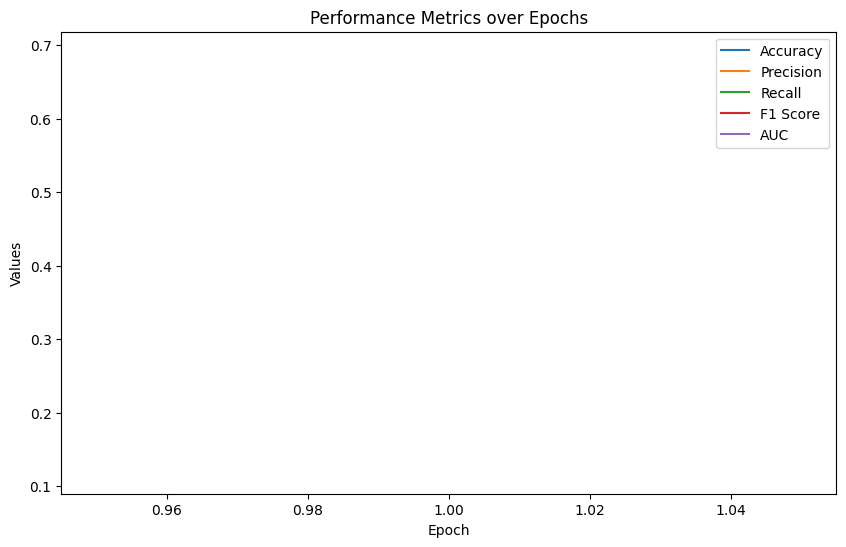

PHQ-9 - 32910 samples: : 5it [00:28,  5.63s/it]


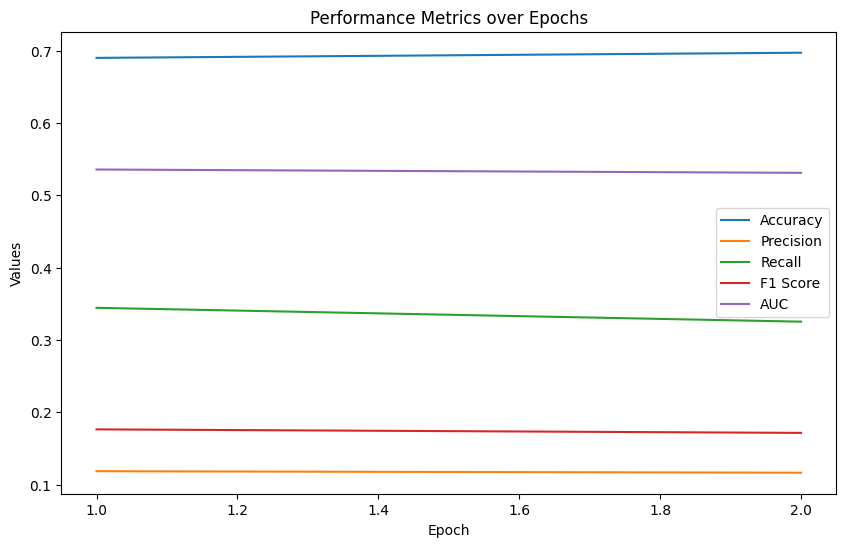

PHQ-9 - 32910 samples: : 5it [00:30,  6.16s/it]


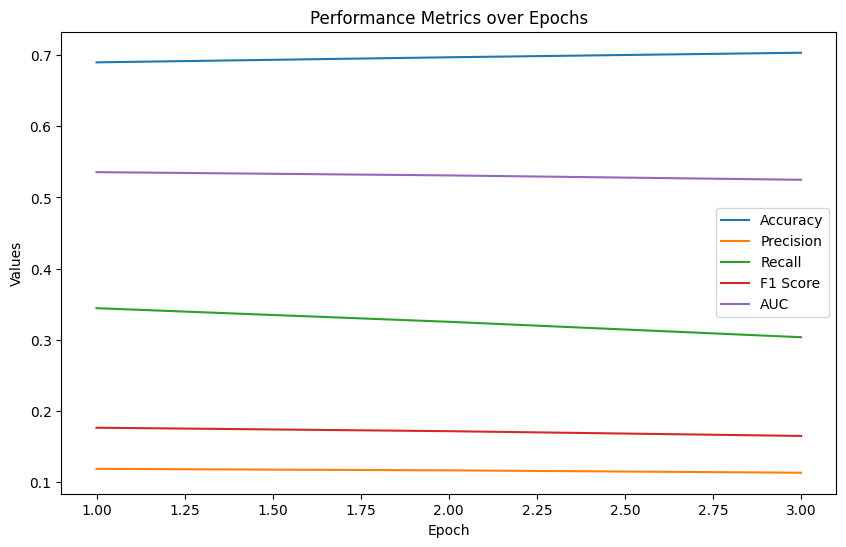

PHQ-9 - 32910 samples: : 5it [00:38,  7.64s/it]


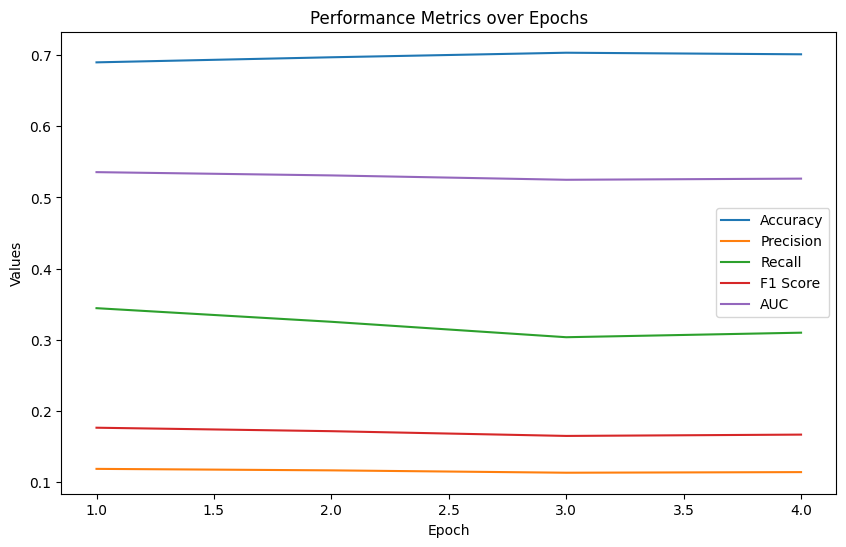

PHQ-9 - 32910 samples: : 5it [00:53, 10.69s/it]


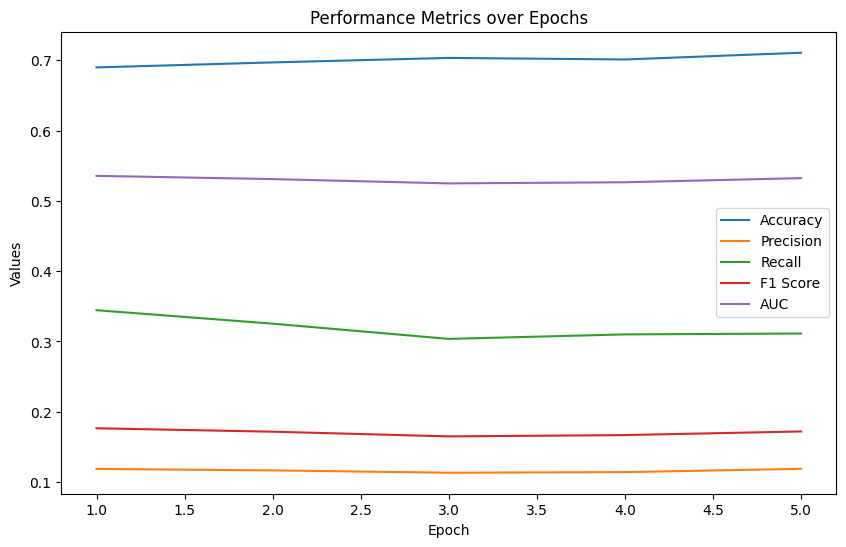

PHQ-9 - 32910 samples: : 5it [01:33, 18.66s/it]


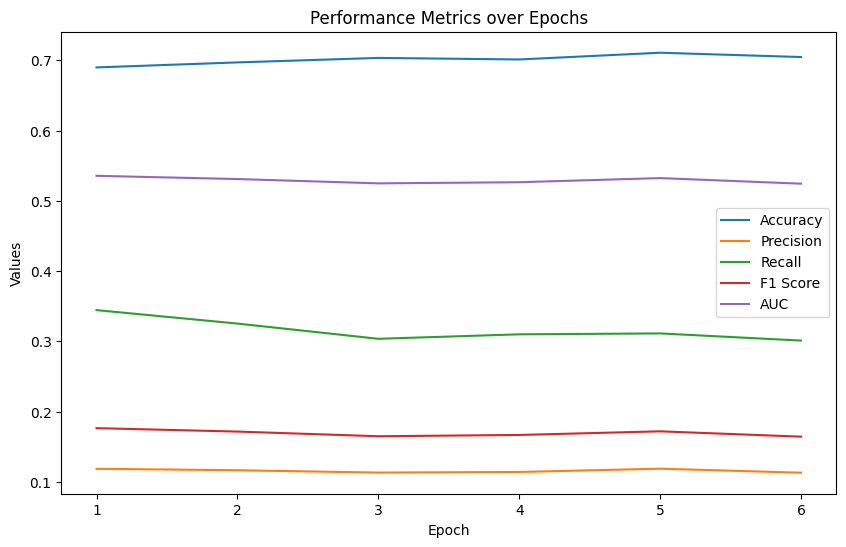

PHQ-9 - 32910 samples: : 5it [00:27,  5.46s/it]


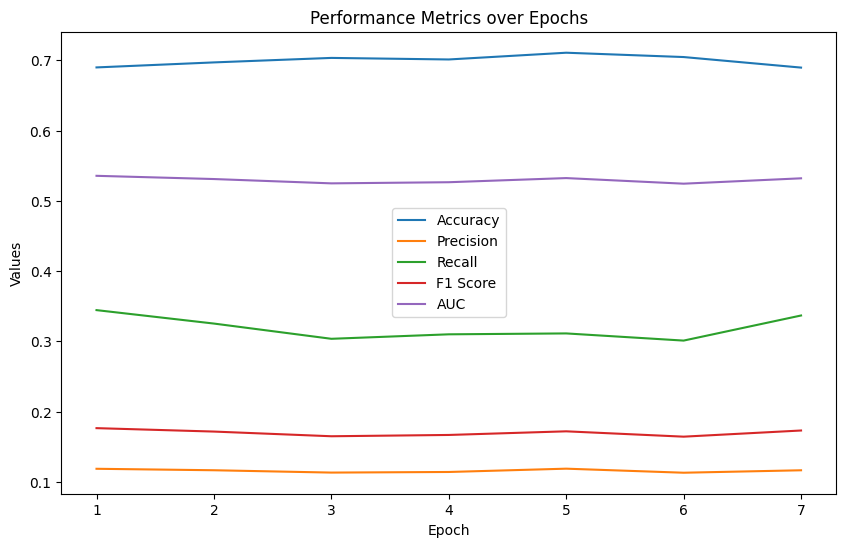

PHQ-9 - 32910 samples: : 5it [00:27,  5.57s/it]


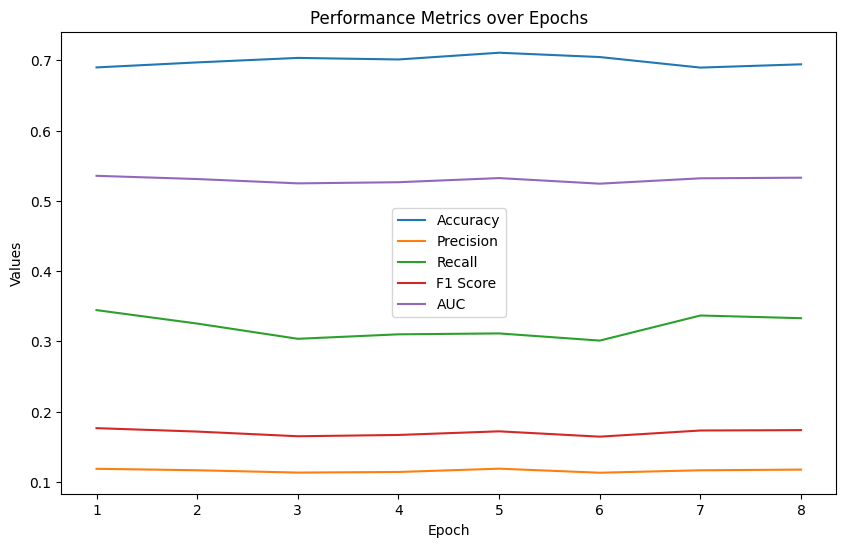

PHQ-9 - 32910 samples: : 5it [00:29,  5.99s/it]


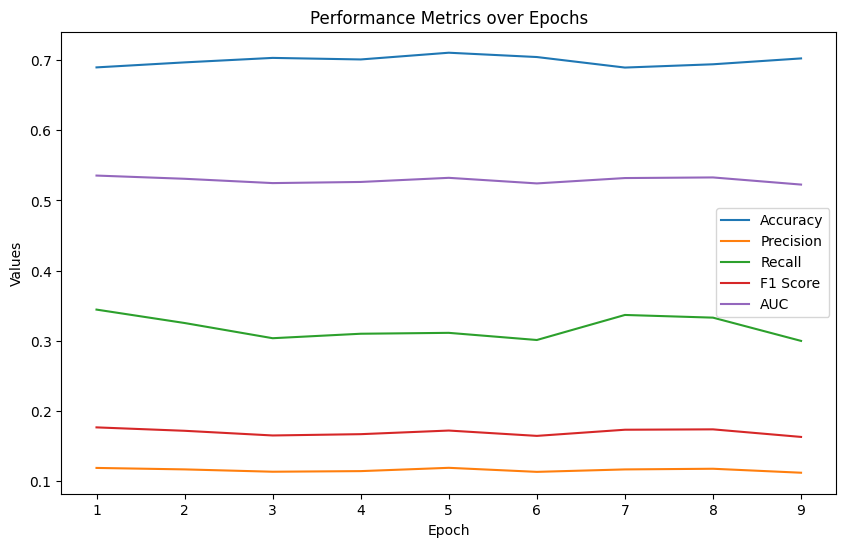

PHQ-9 - 32910 samples: : 5it [00:36,  7.20s/it]


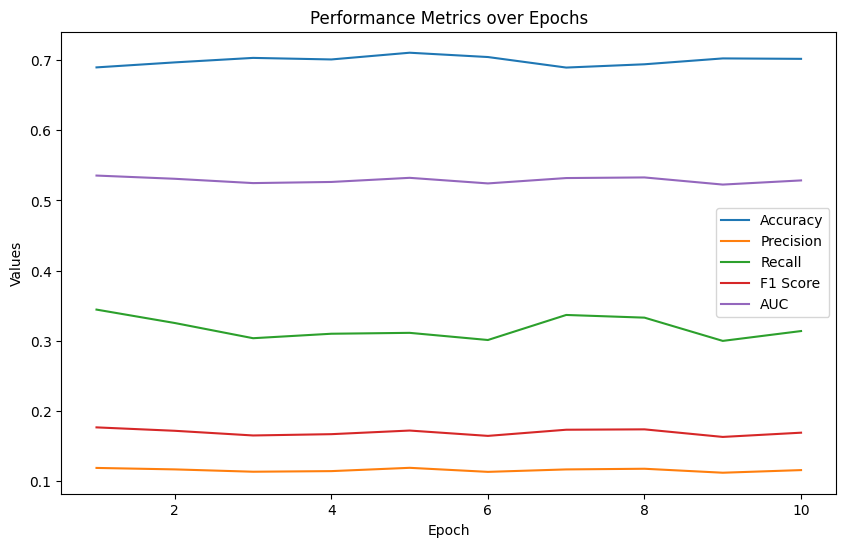

PHQ-9 - 32910 samples: : 5it [00:50, 10.03s/it]


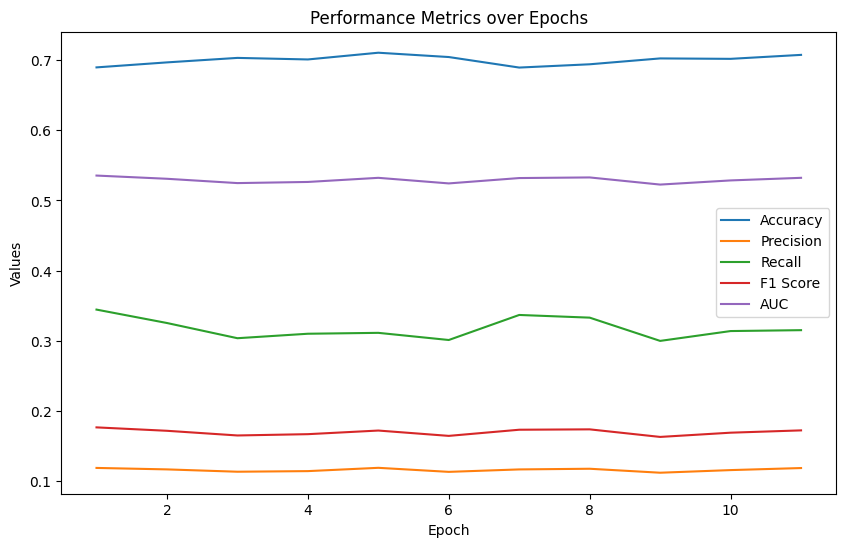

PHQ-9 - 32910 samples: : 5it [01:30, 18.02s/it]


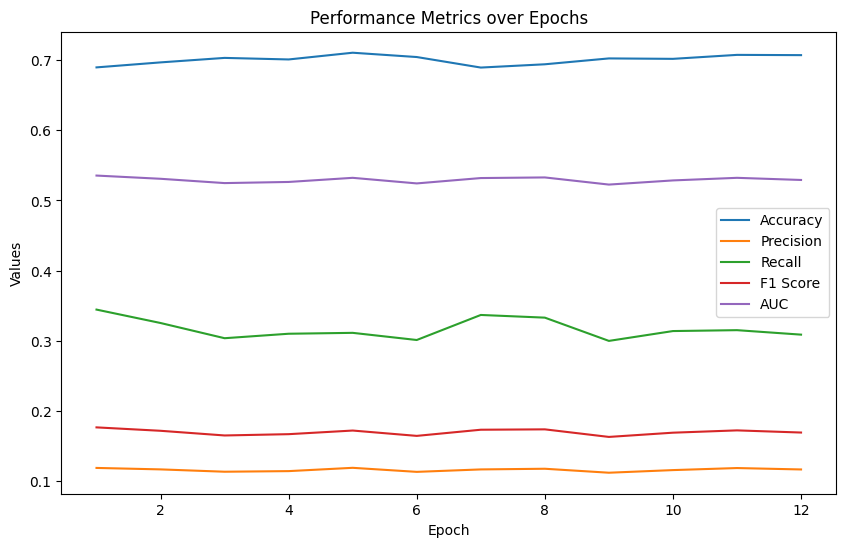

PHQ-9 - 32910 samples: : 5it [00:40,  8.19s/it]


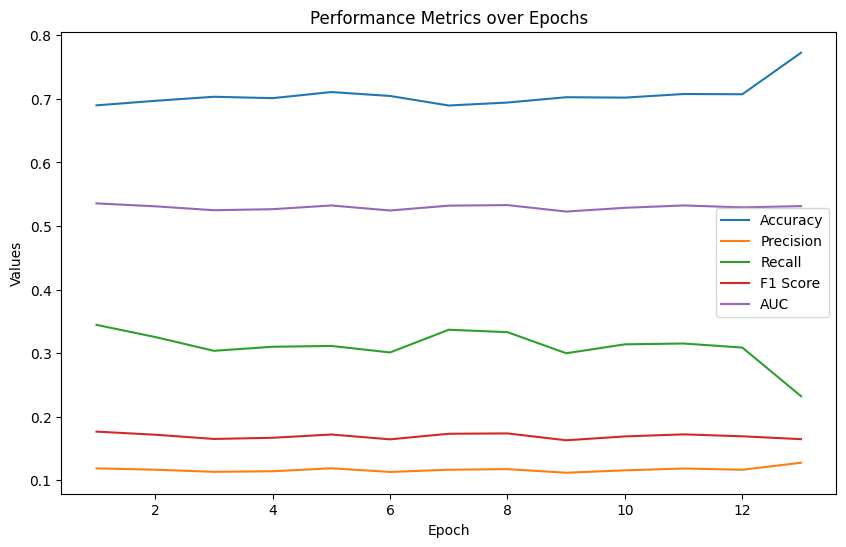

PHQ-9 - 32910 samples: : 5it [00:44,  8.85s/it]


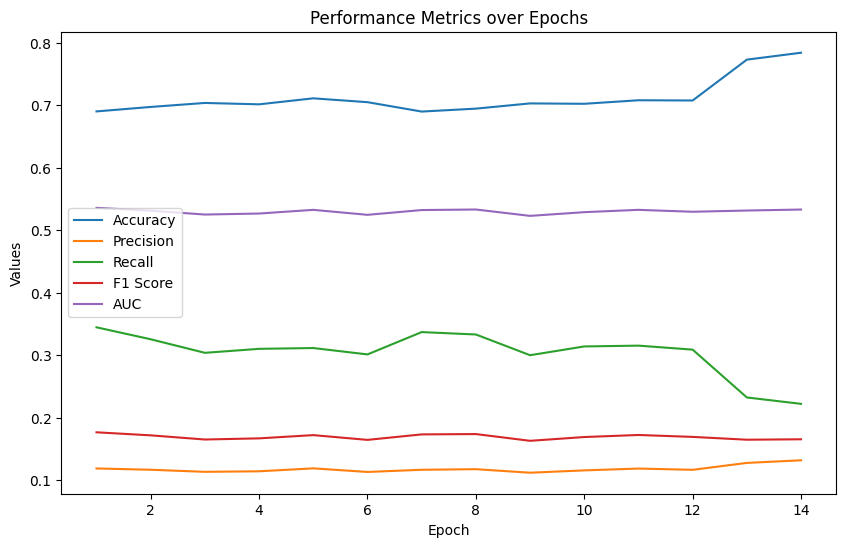

PHQ-9 - 32910 samples: : 5it [00:51, 10.21s/it]


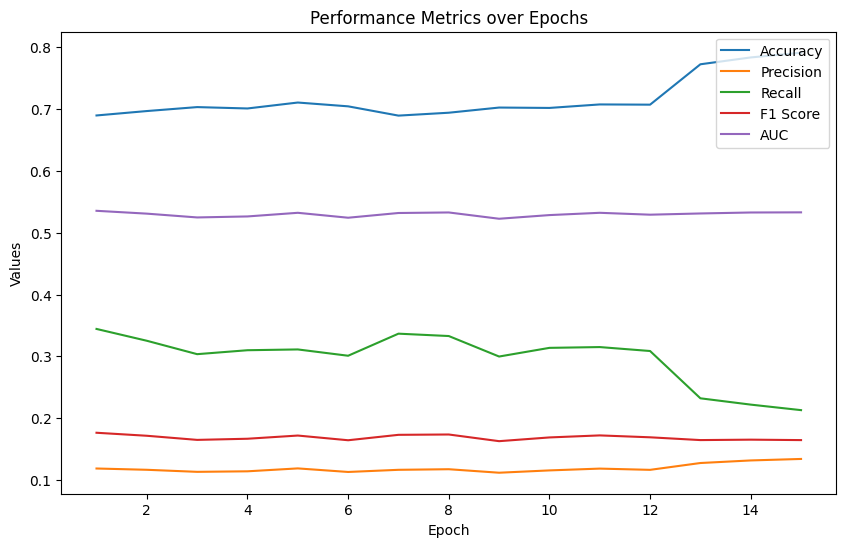

PHQ-9 - 32910 samples: : 5it [01:08, 13.75s/it]


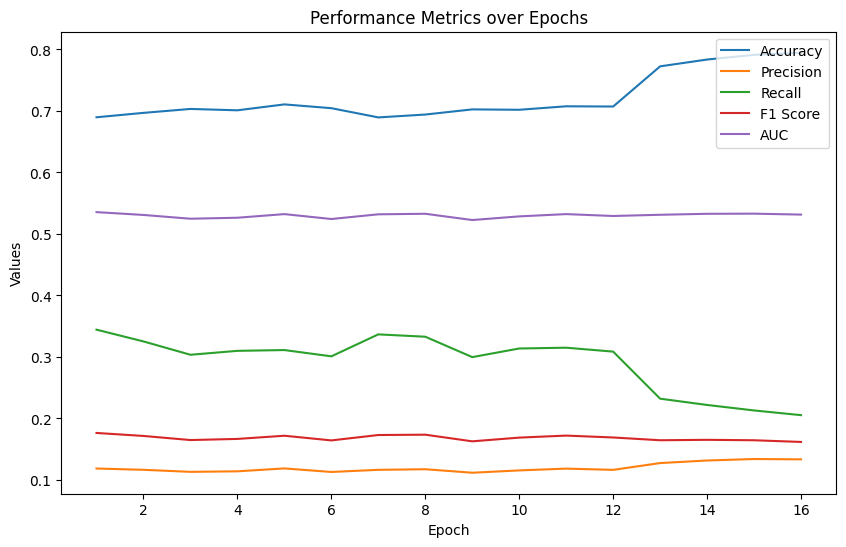

PHQ-9 - 32910 samples: : 5it [01:50, 22.11s/it]


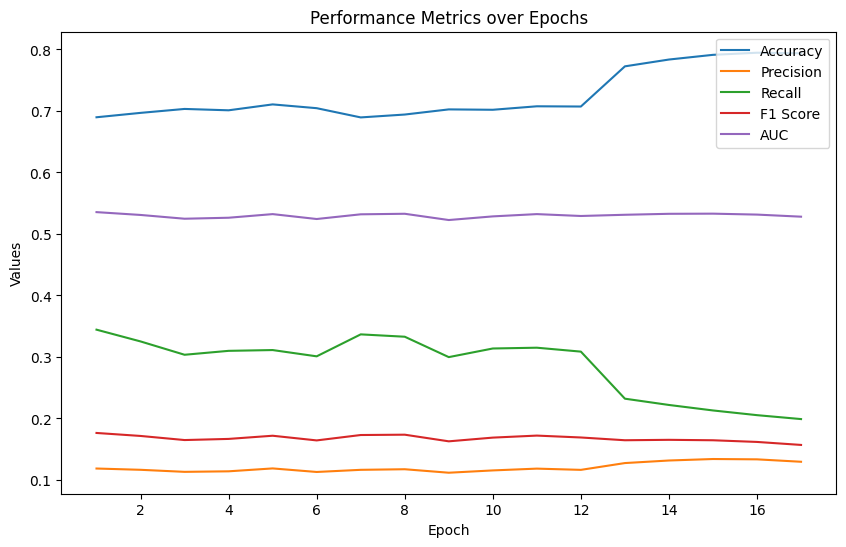

PHQ-9 - 32910 samples: : 5it [03:16, 39.32s/it]


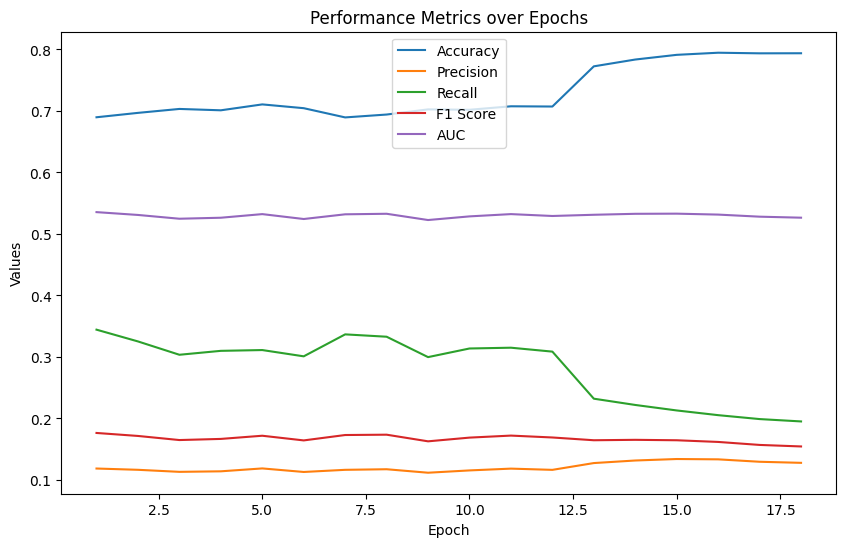

PHQ-9 - 32910 samples: : 5it [00:40,  8.16s/it]


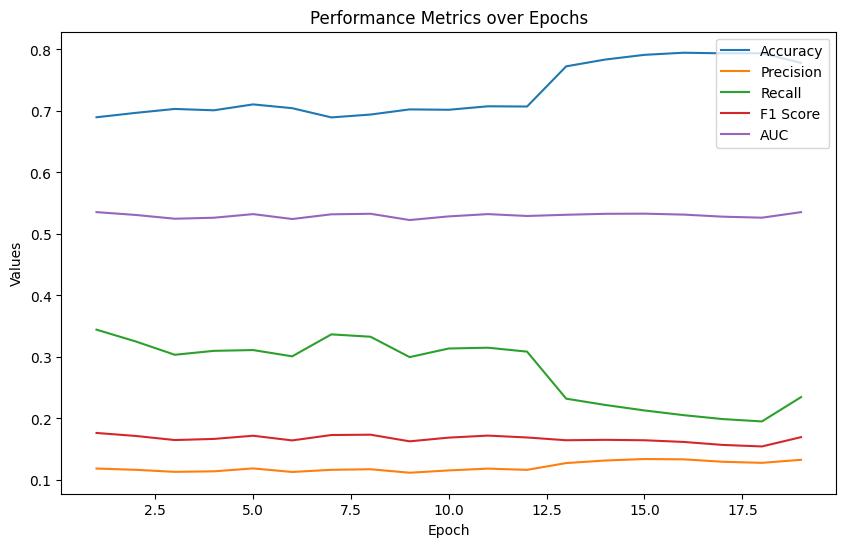

PHQ-9 - 32910 samples: : 5it [00:43,  8.78s/it]


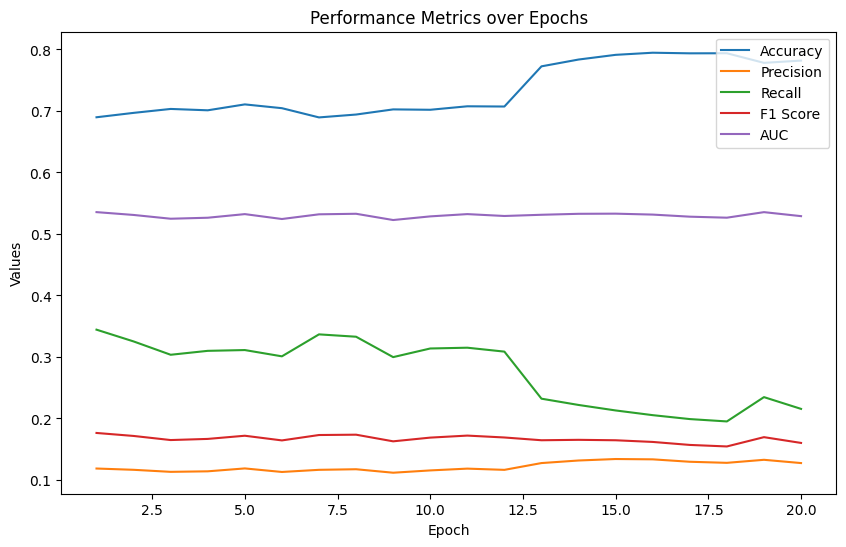

PHQ-9 - 32910 samples: : 5it [00:50, 10.09s/it]


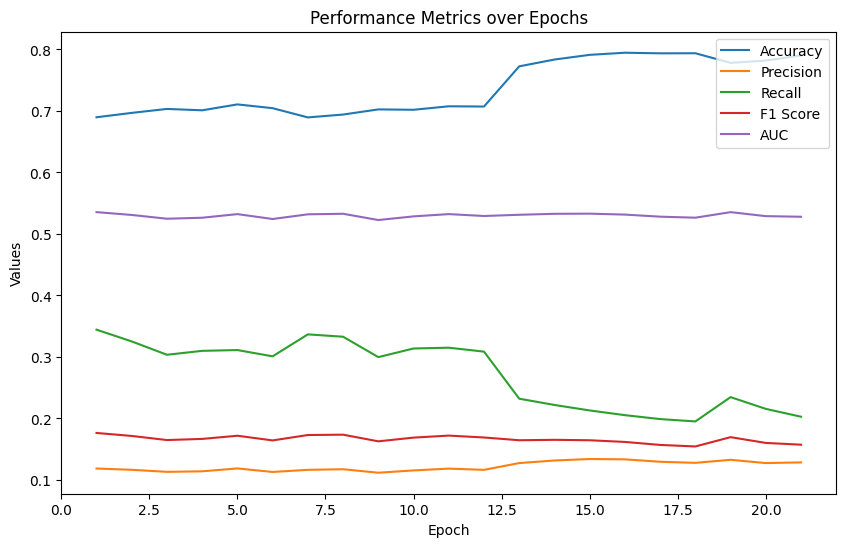

PHQ-9 - 32910 samples: : 5it [01:05, 13.02s/it]


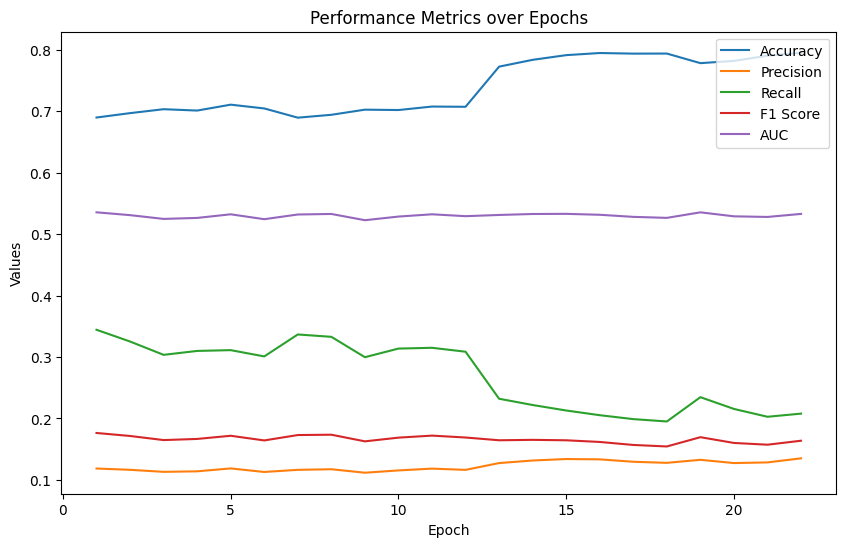

PHQ-9 - 32910 samples: : 5it [01:46, 21.38s/it]


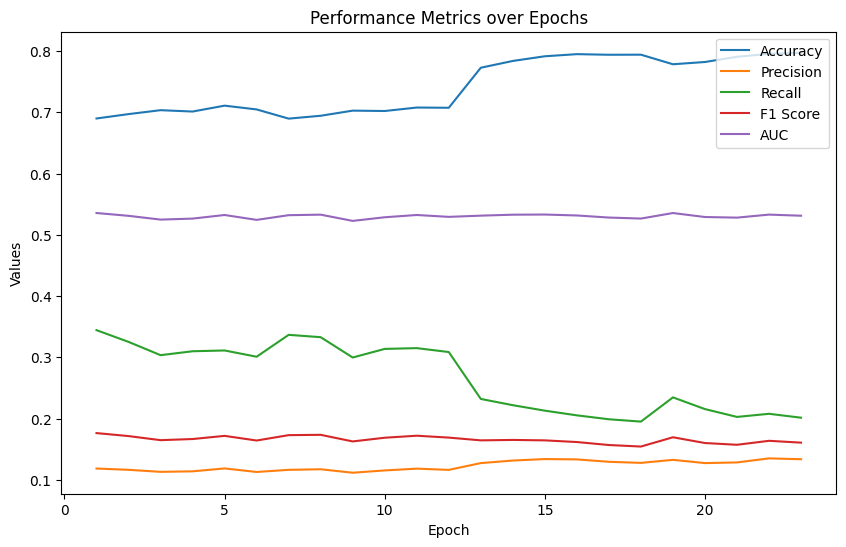

PHQ-9 - 32910 samples: : 5it [03:12, 38.48s/it]


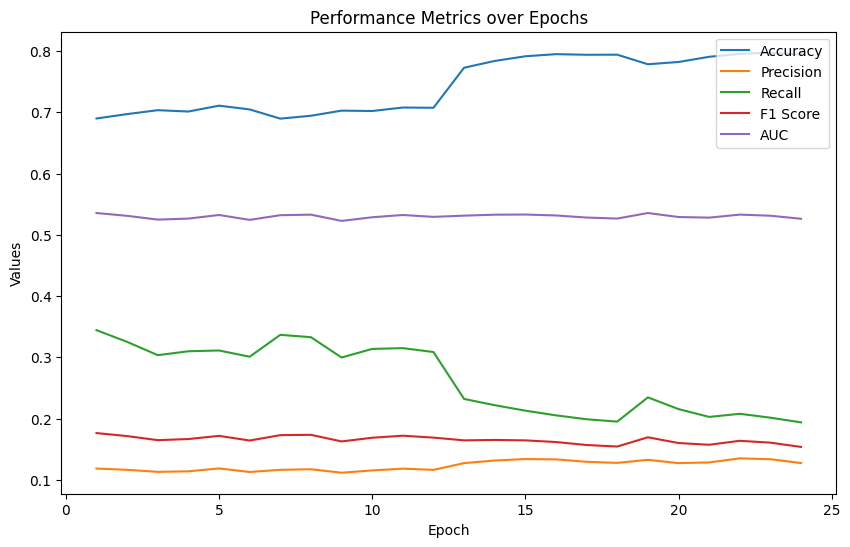

PHQ-9 - 32910 samples: : 5it [01:09, 13.92s/it]


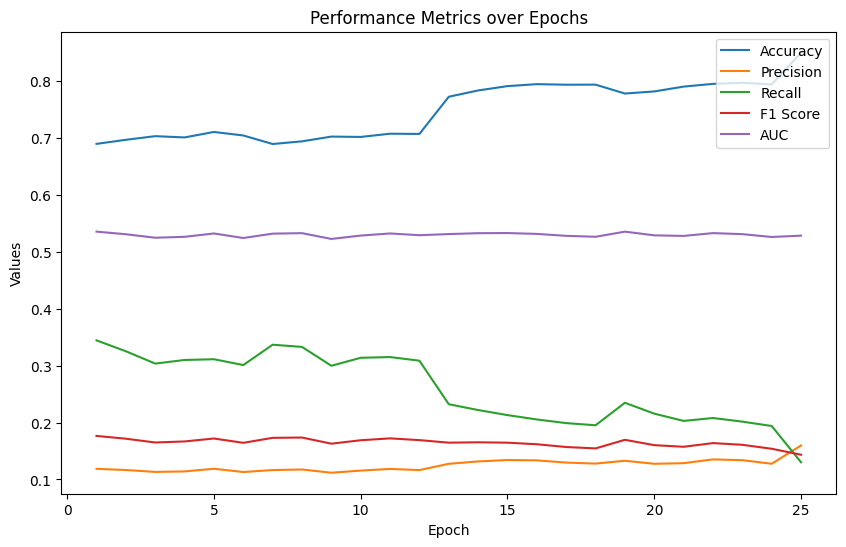

PHQ-9 - 32910 samples: : 5it [01:16, 15.23s/it]


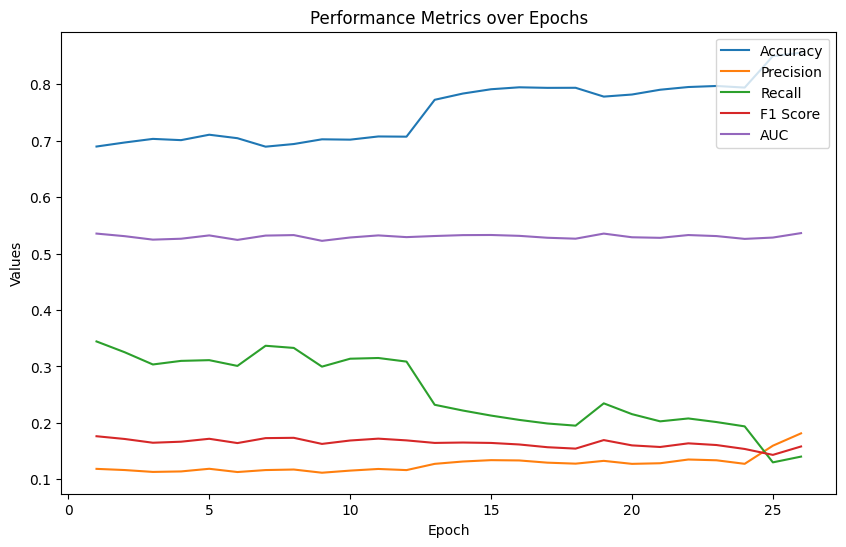

PHQ-9 - 32910 samples: : 5it [01:38, 19.61s/it]


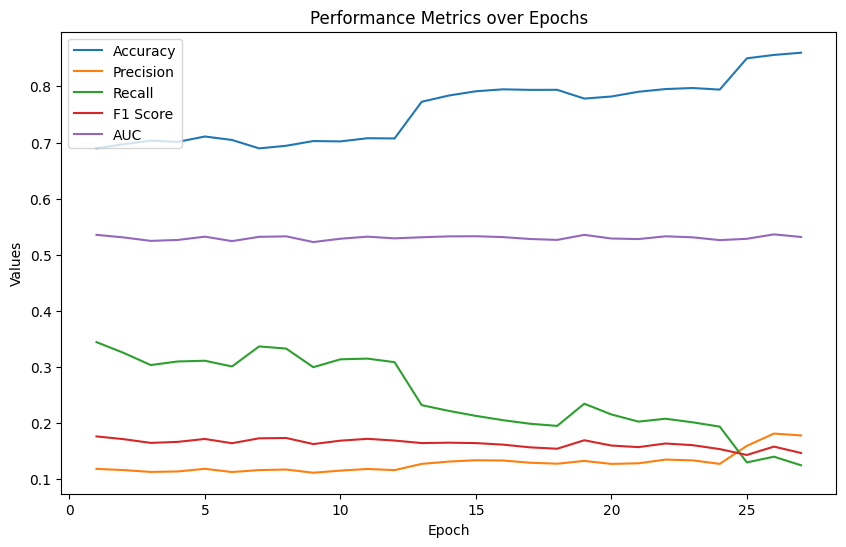

PHQ-9 - 32910 samples: : 5it [02:13, 26.72s/it]


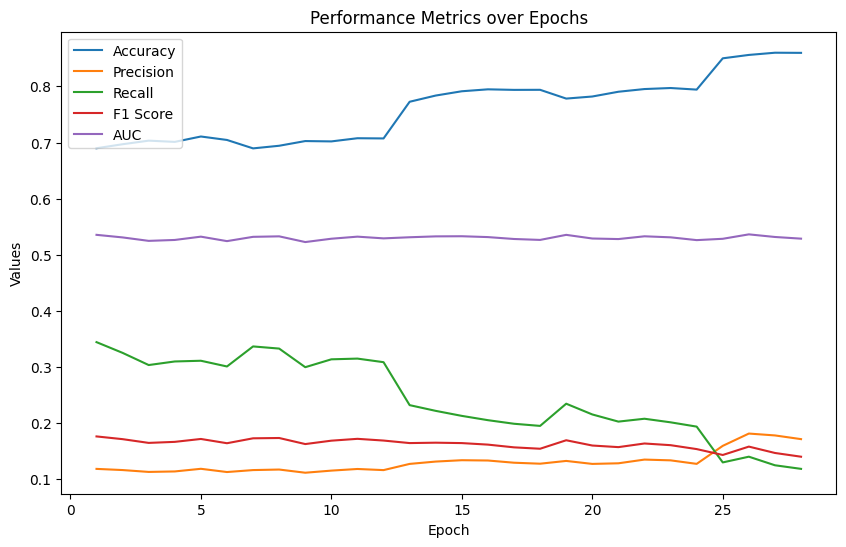

PHQ-9 - 32910 samples: : 5it [03:39, 43.91s/it]


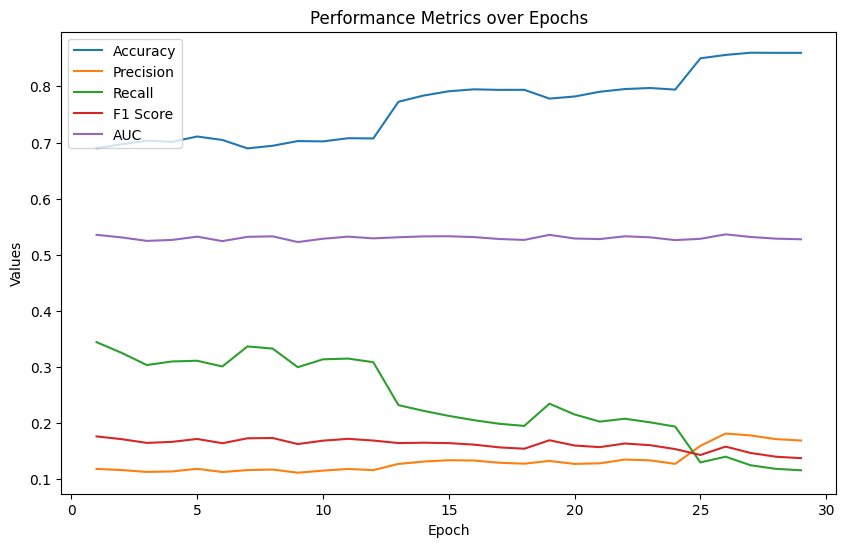

PHQ-9 - 32910 samples: : 5it [06:33, 78.71s/it]


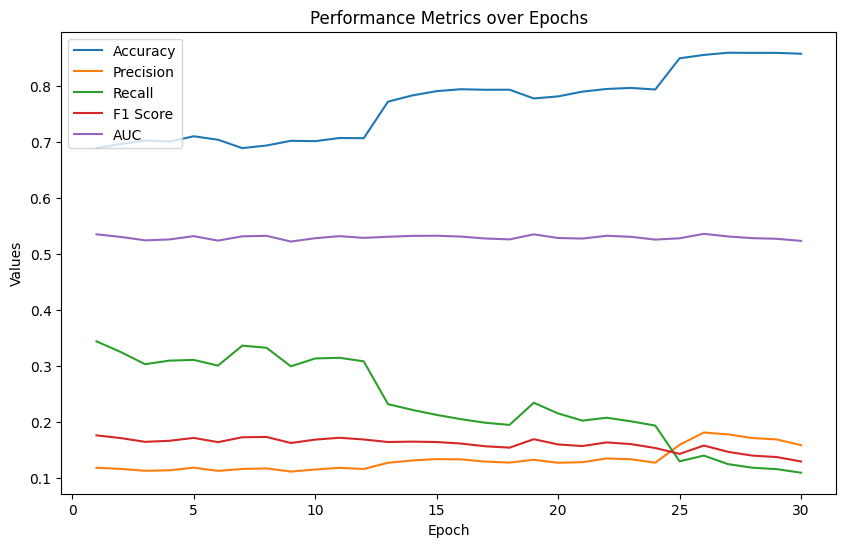

PHQ-9 - 32910 samples: : 5it [01:08, 13.79s/it]


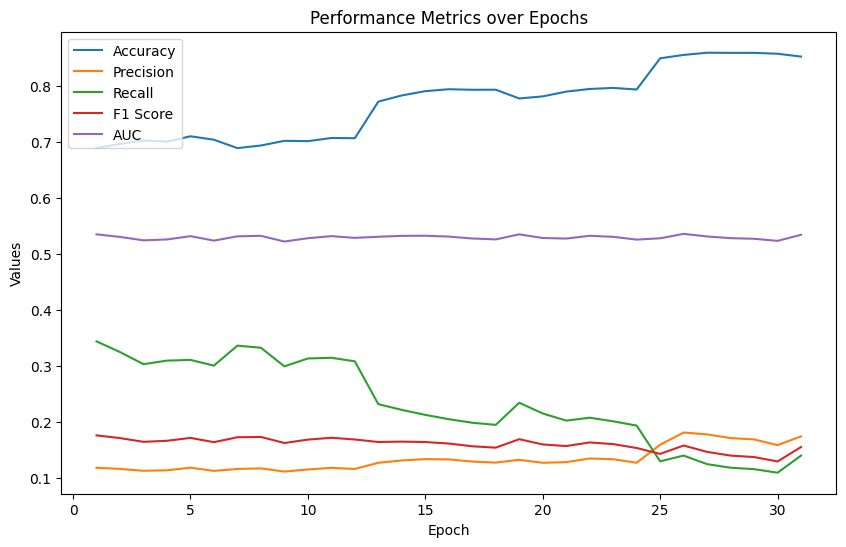

PHQ-9 - 32910 samples: : 5it [01:15, 15.09s/it]


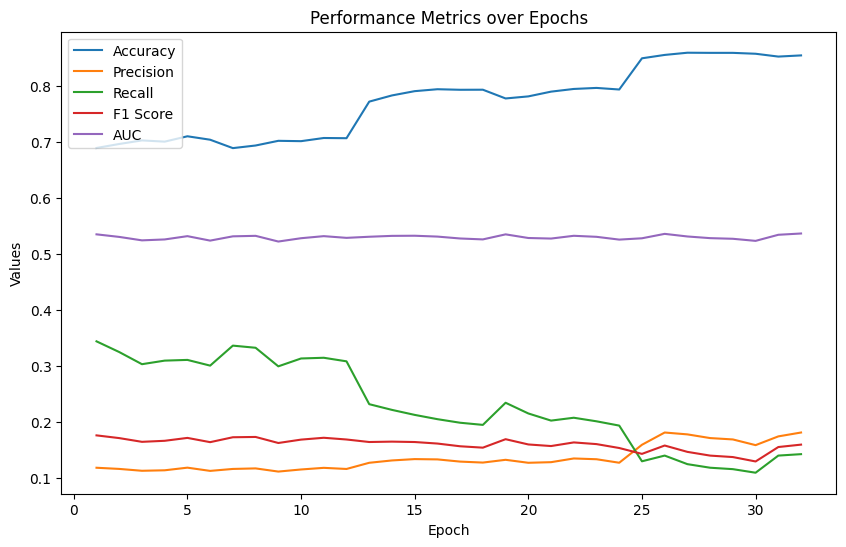

PHQ-9 - 32910 samples: : 5it [01:31, 18.39s/it]


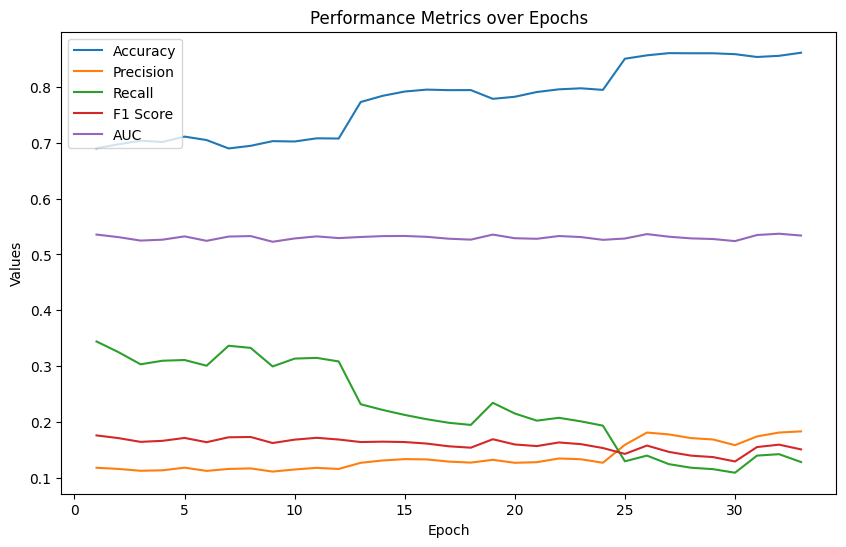

PHQ-9 - 32910 samples: : 5it [02:10, 26.14s/it]


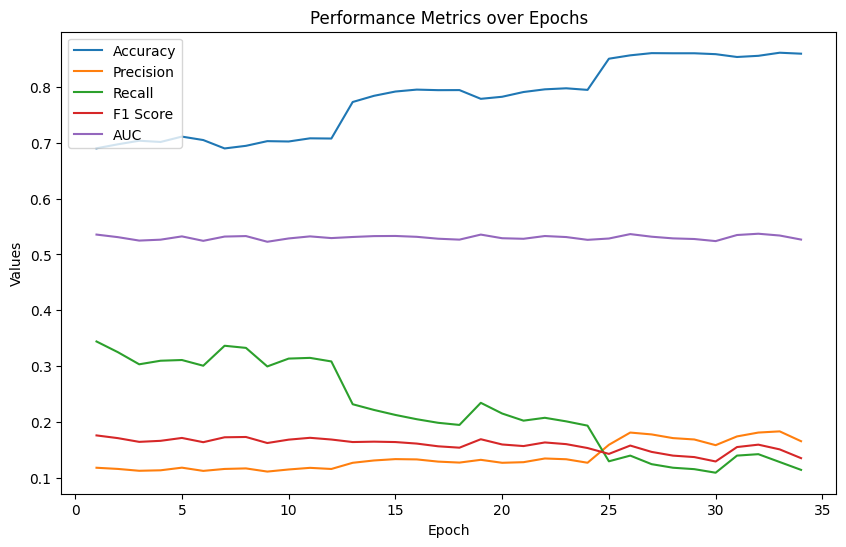

PHQ-9 - 32910 samples: : 5it [03:34, 42.93s/it]


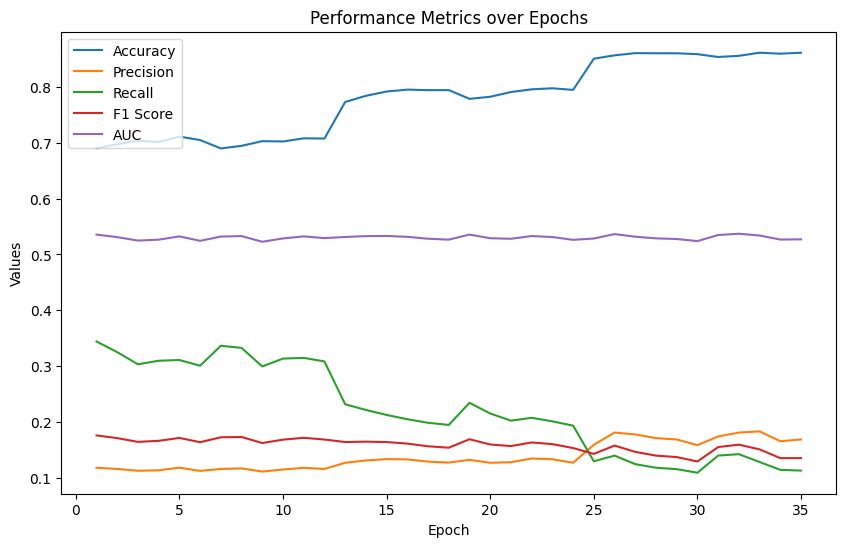

PHQ-9 - 32910 samples: : 5it [06:23, 76.74s/it]


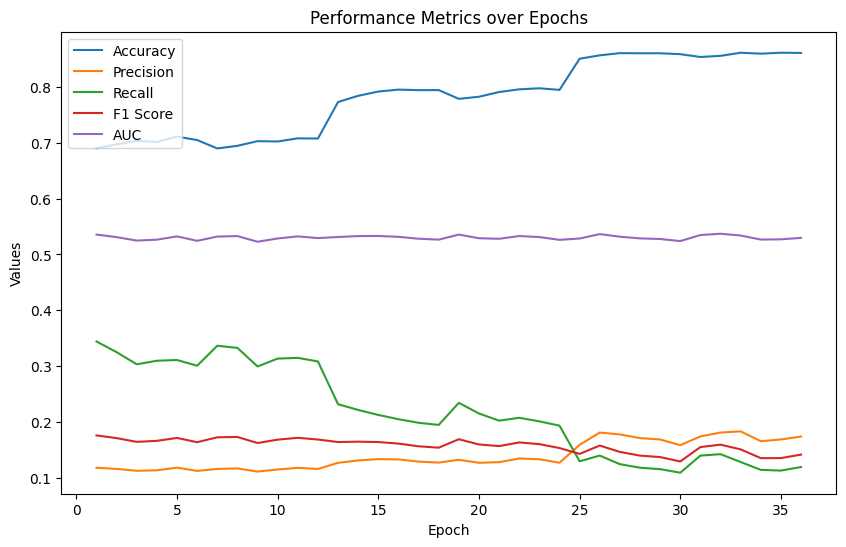

PHQ-9 - 32910 samples: : 5it [02:10, 26.10s/it]


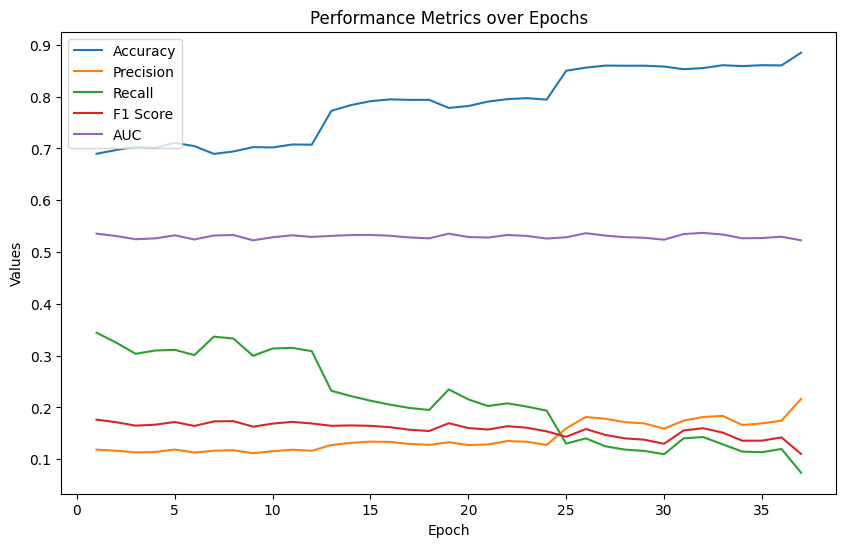

PHQ-9 - 32910 samples: : 5it [02:27, 29.59s/it]


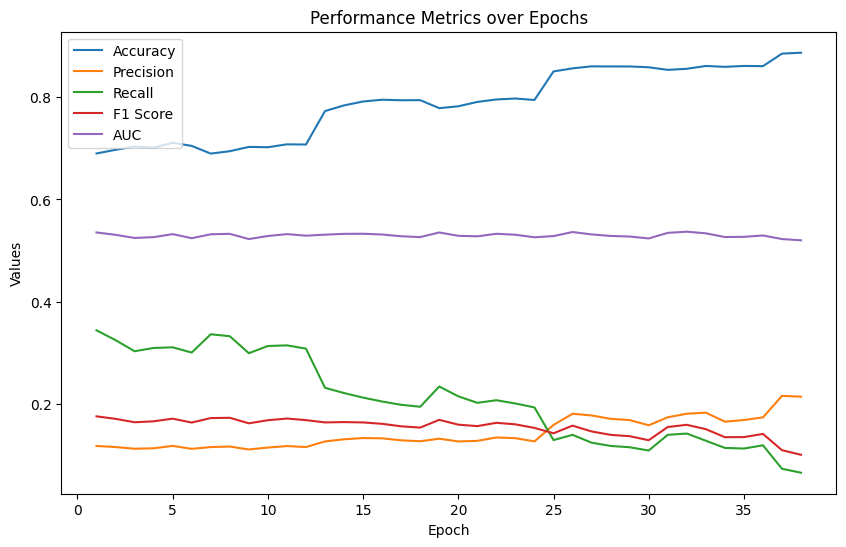

PHQ-9 - 32910 samples: : 5it [03:07, 37.52s/it]


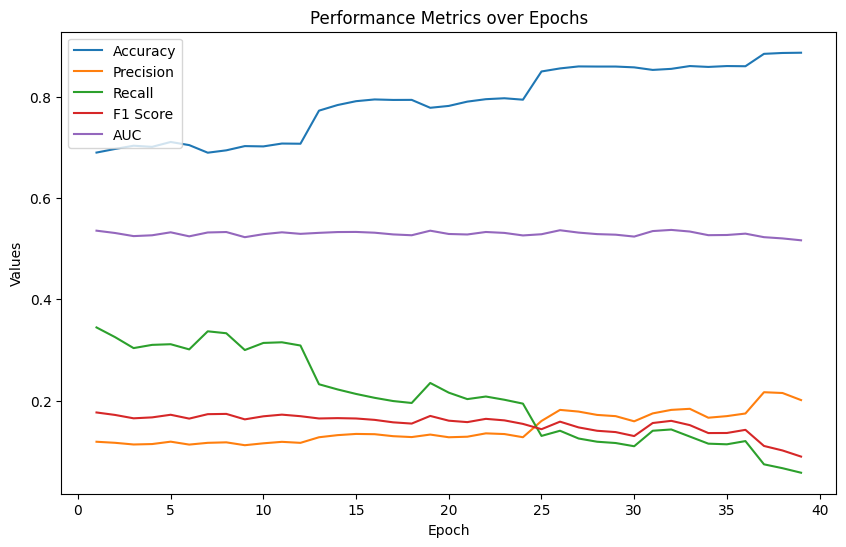

PHQ-9 - 32910 samples: : 5it [04:26, 53.35s/it]


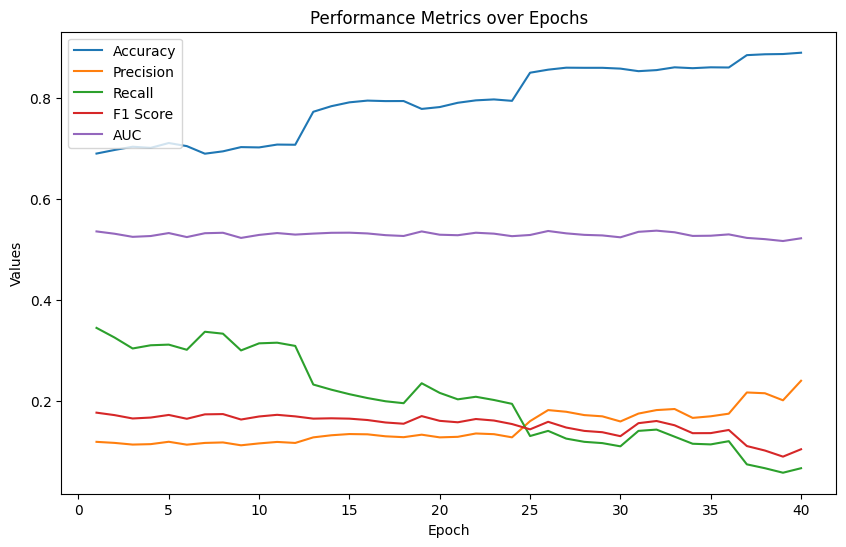

PHQ-9 - 32910 samples: : 5it [07:30, 90.13s/it]


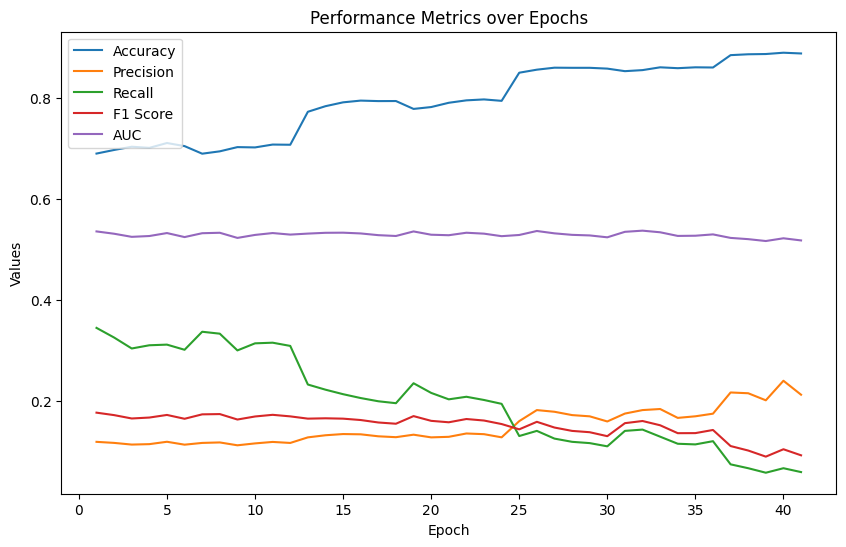

PHQ-9 - 32910 samples: : 5it [13:17, 159.59s/it]


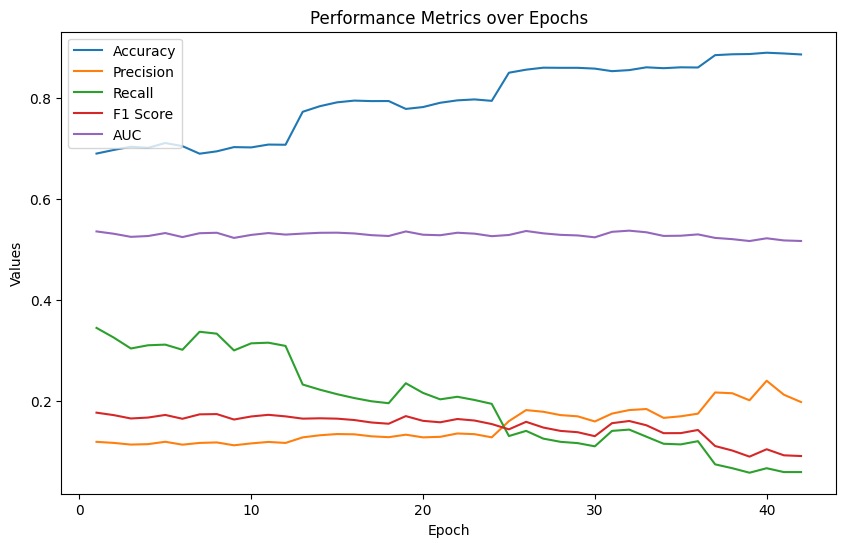

PHQ-9 - 32910 samples: : 5it [02:10, 26.18s/it]


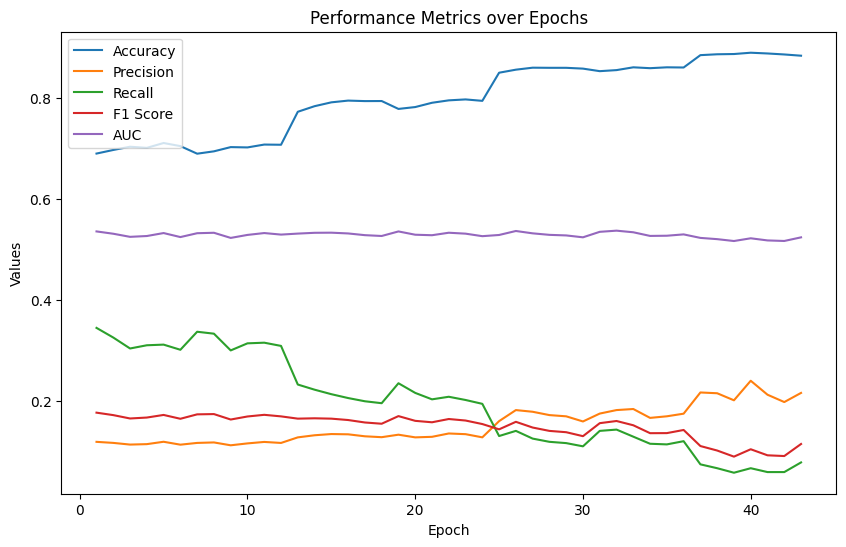

PHQ-9 - 32910 samples: : 5it [02:26, 29.35s/it]


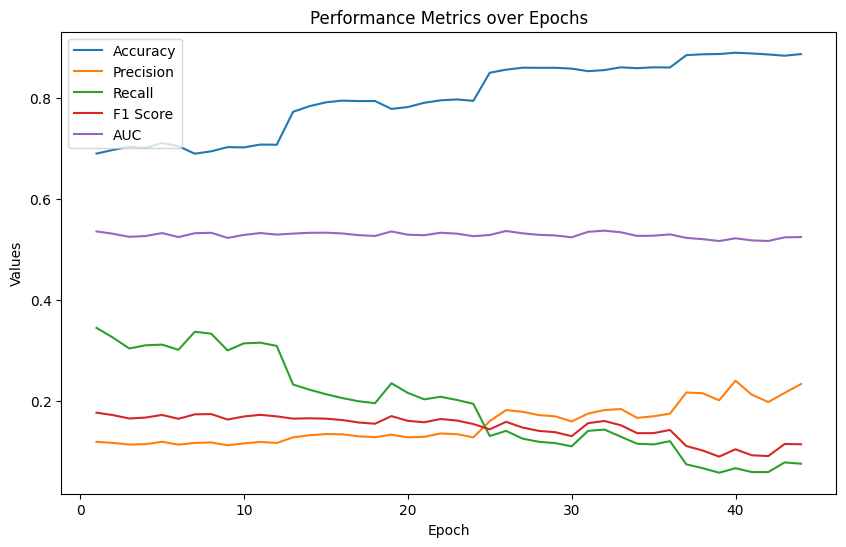

PHQ-9 - 32910 samples: : 5it [03:04, 36.84s/it]


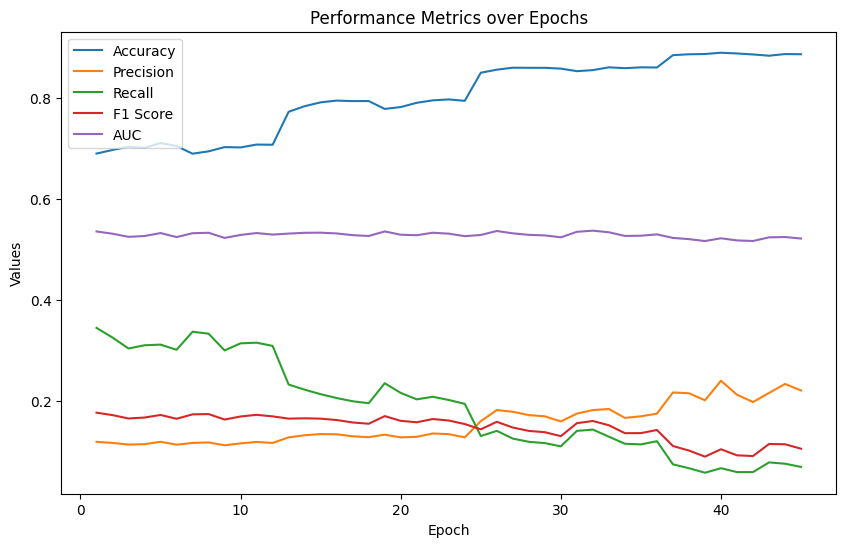

PHQ-9 - 32910 samples: : 5it [04:20, 52.18s/it]


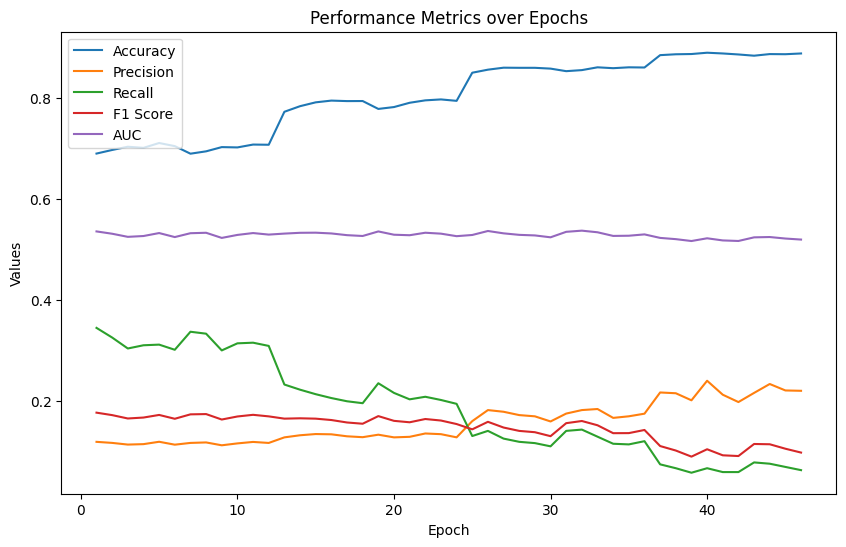

PHQ-9 - 32910 samples: : 5it [07:07, 85.60s/it]


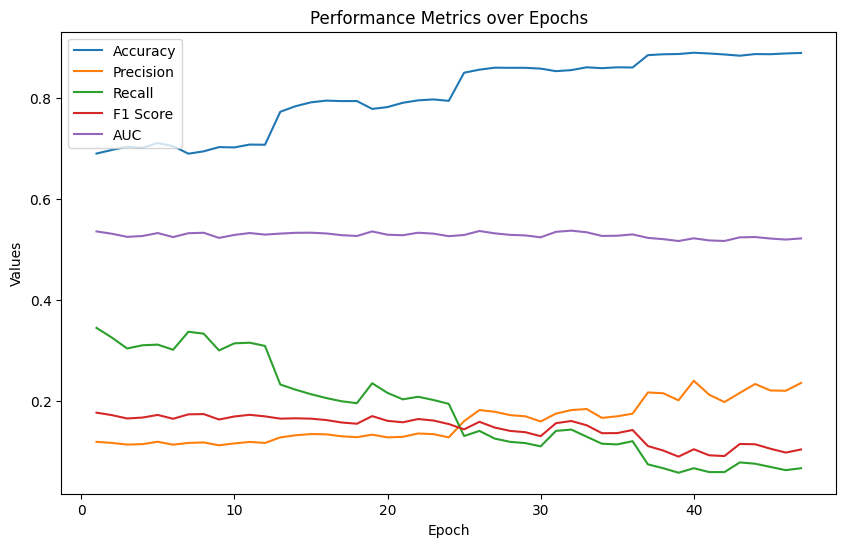

PHQ-9 - 32910 samples: : 5it [12:52, 154.59s/it]


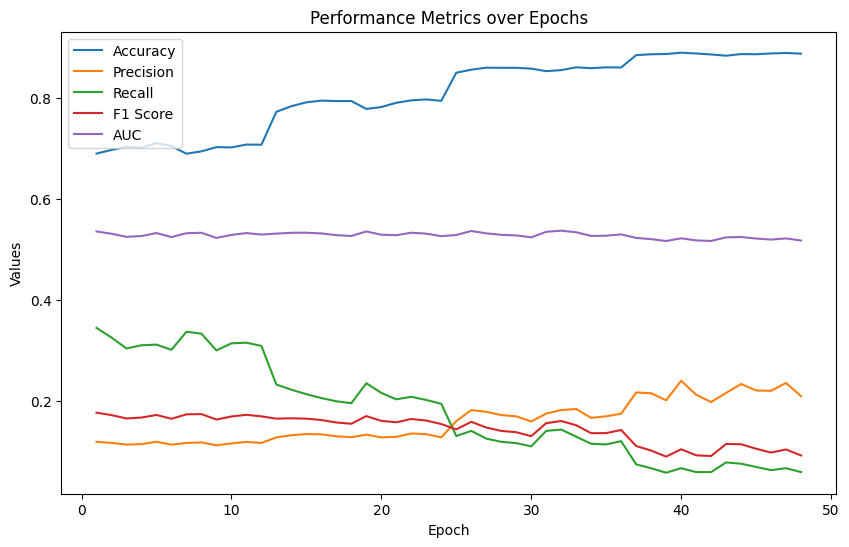

PHQ-9 - 32910 samples: : 5it [04:35, 55.13s/it]


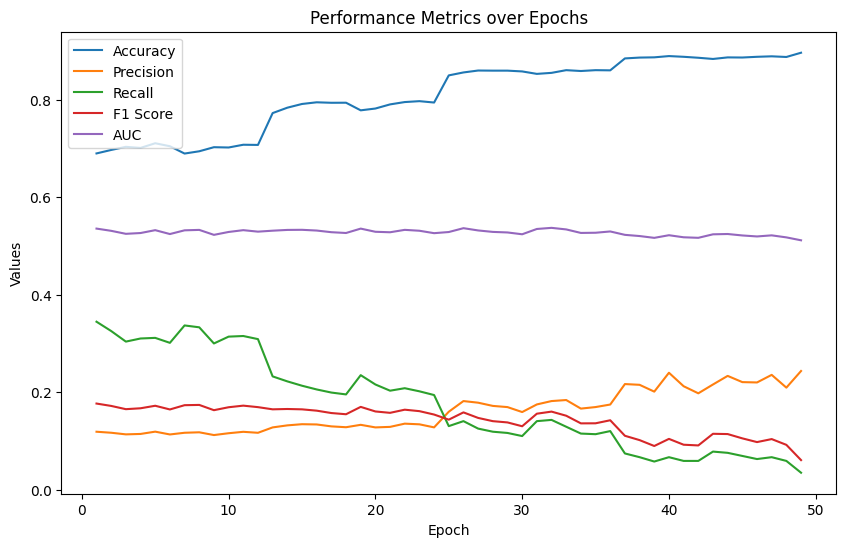

PHQ-9 - 32910 samples: : 5it [05:06, 61.25s/it]


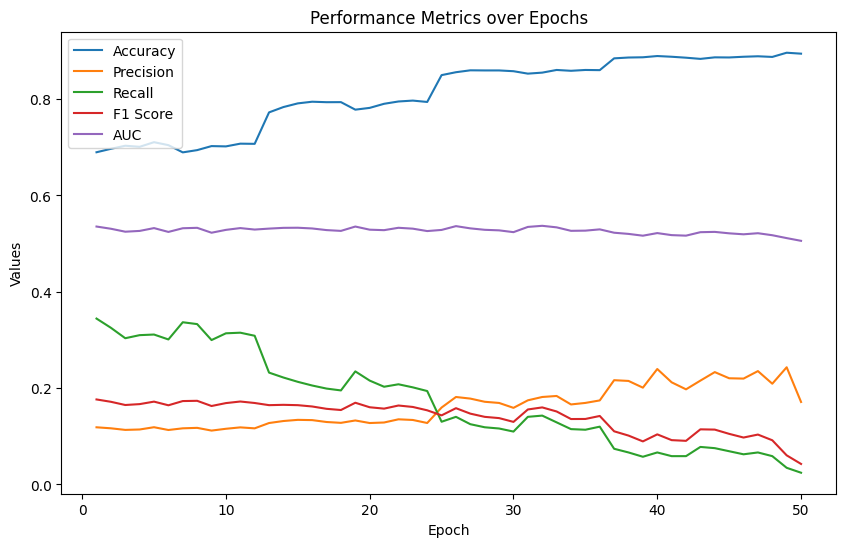

PHQ-9 - 32910 samples: : 5it [06:24, 76.83s/it]


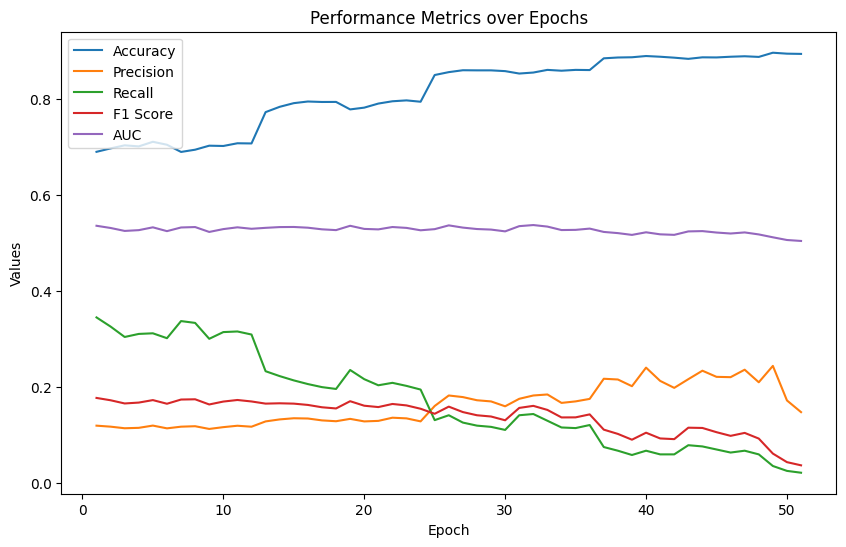

PHQ-9 - 32910 samples: : 5it [09:16, 111.22s/it]


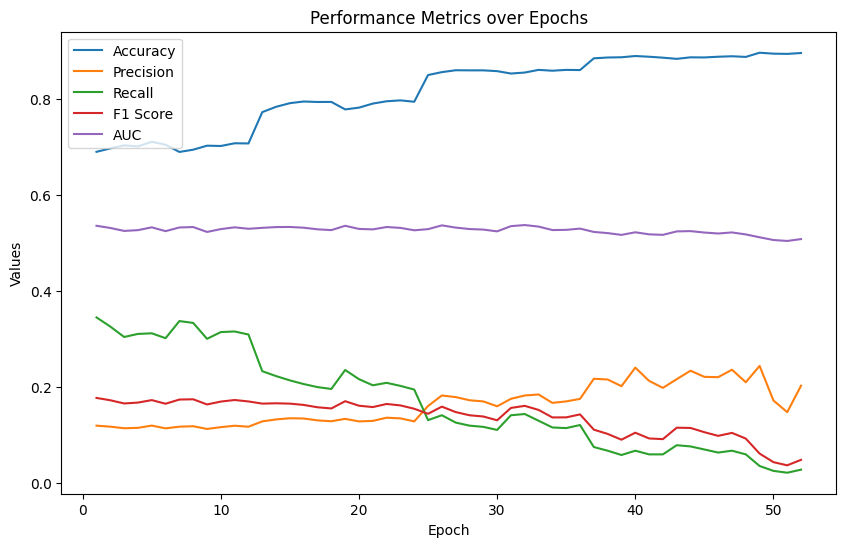

PHQ-9 - 32910 samples: : 5it [15:26, 185.25s/it]


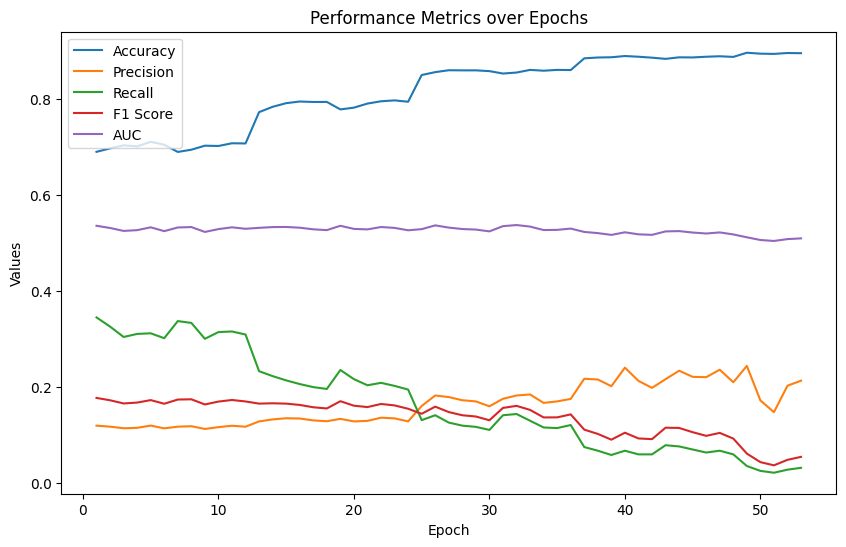

PHQ-9 - 32910 samples: : 5it [28:02, 336.47s/it]


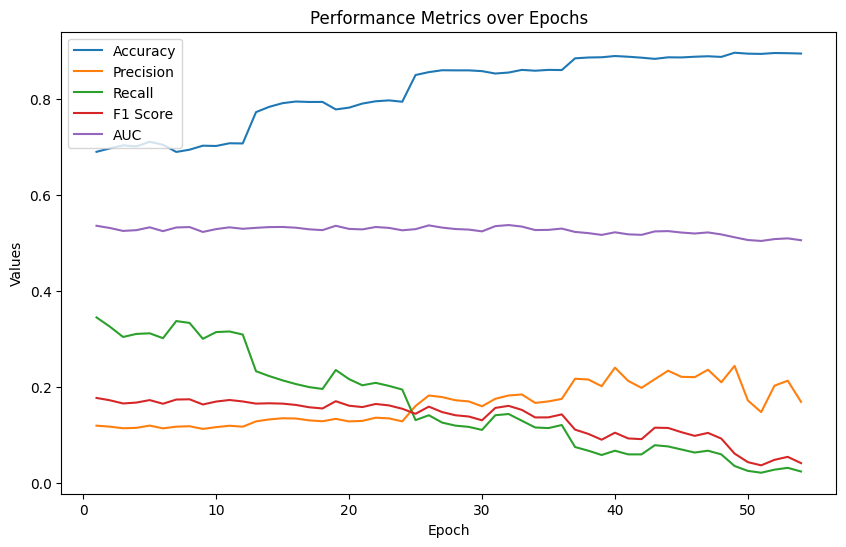

PHQ-9 - 32910 samples: : 5it [04:21, 52.25s/it]


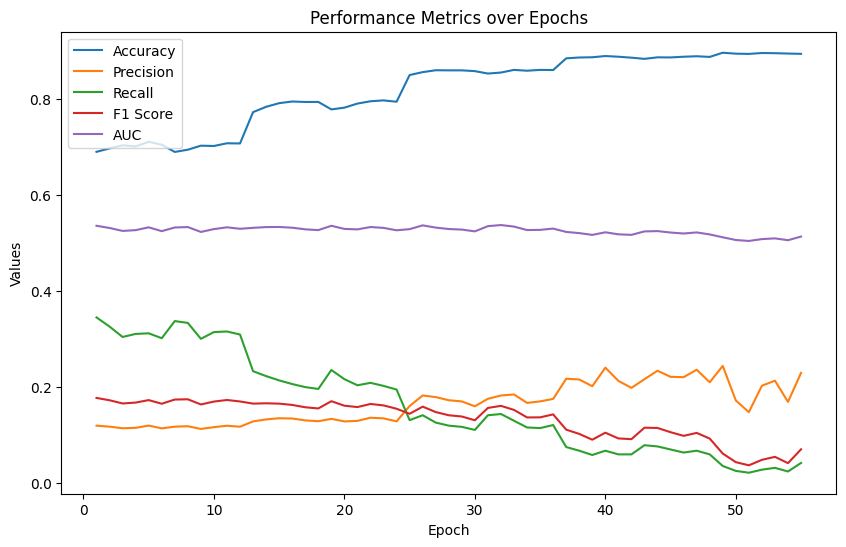

PHQ-9 - 32910 samples: : 5it [04:51, 58.39s/it]


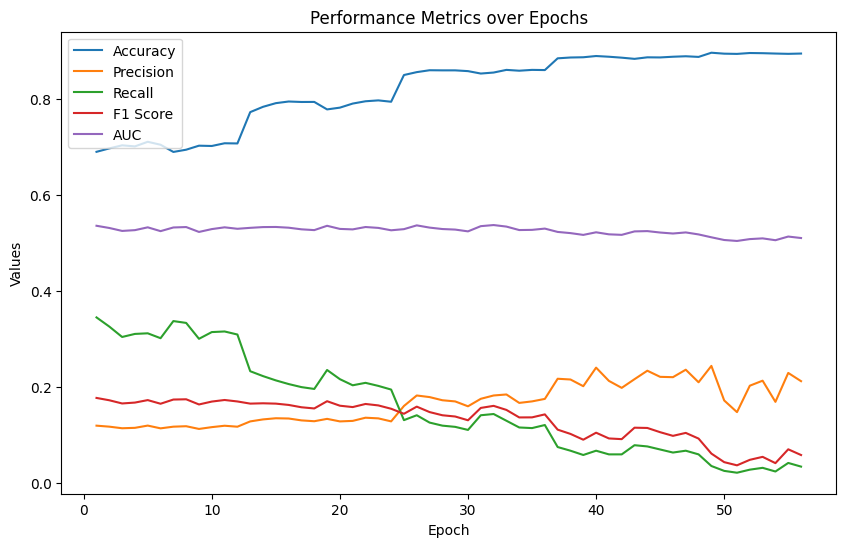

PHQ-9 - 32910 samples: : 5it [06:08, 73.73s/it]


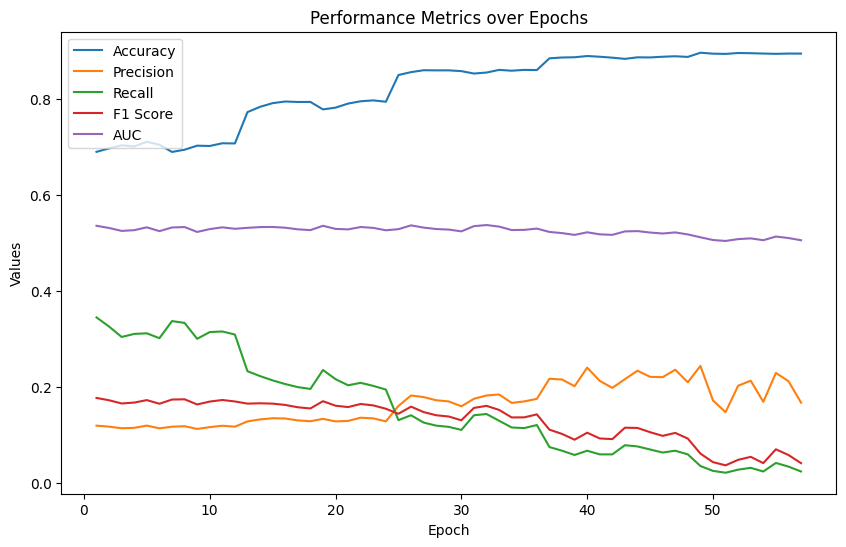

PHQ-9 - 32910 samples: : 5it [08:52, 106.47s/it]


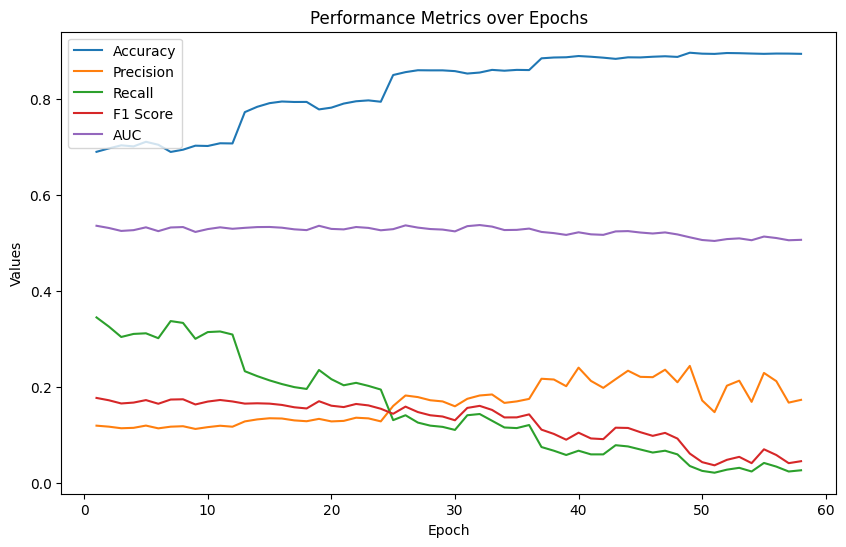

PHQ-9 - 32910 samples: : 5it [14:33, 174.66s/it]


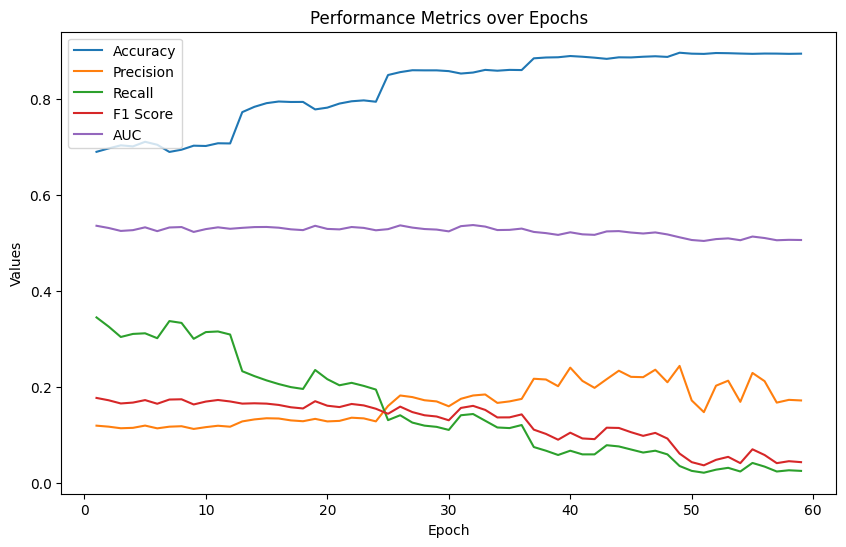

PHQ-9 - 32910 samples: : 5it [26:18, 315.79s/it]


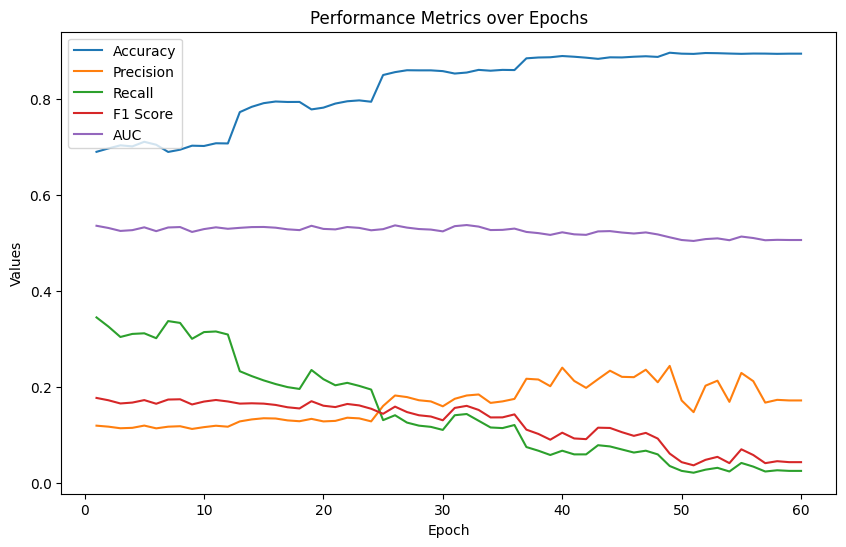

PHQ-9 - 32910 samples: : 5it [08:55, 107.15s/it]


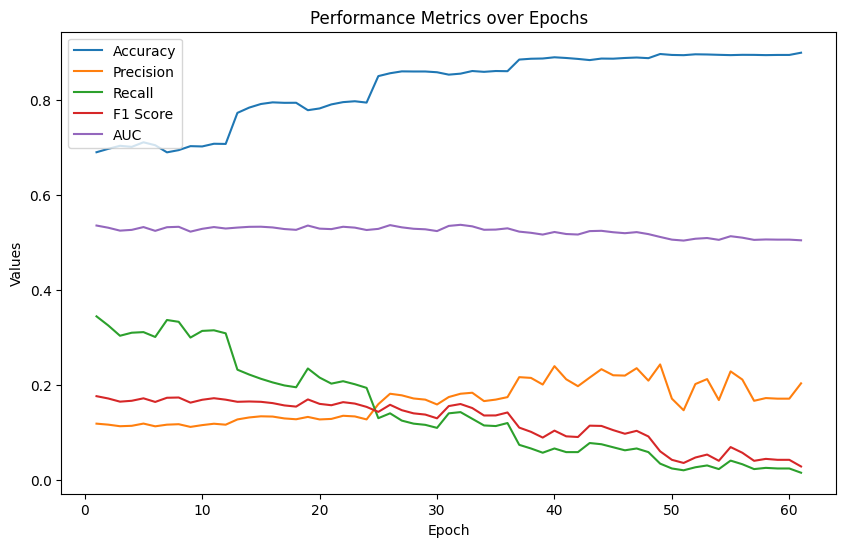

PHQ-9 - 32910 samples: : 5it [09:58, 119.75s/it]


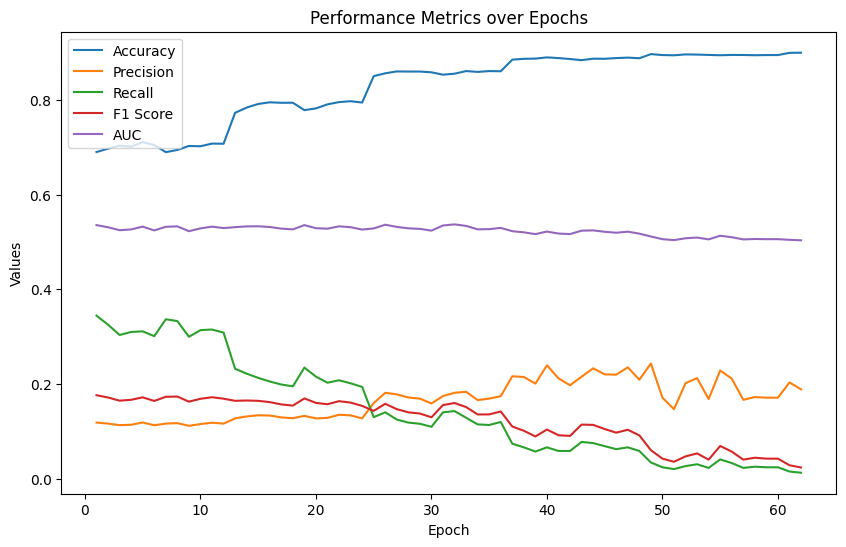

PHQ-9 - 32910 samples: : 5it [12:29, 149.85s/it]


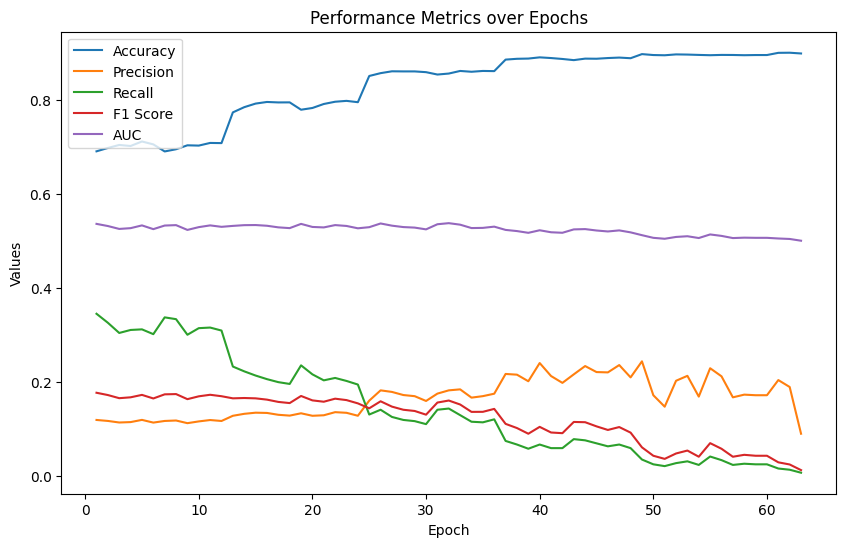

PHQ-9 - 32910 samples: : 5it [18:04, 216.93s/it]


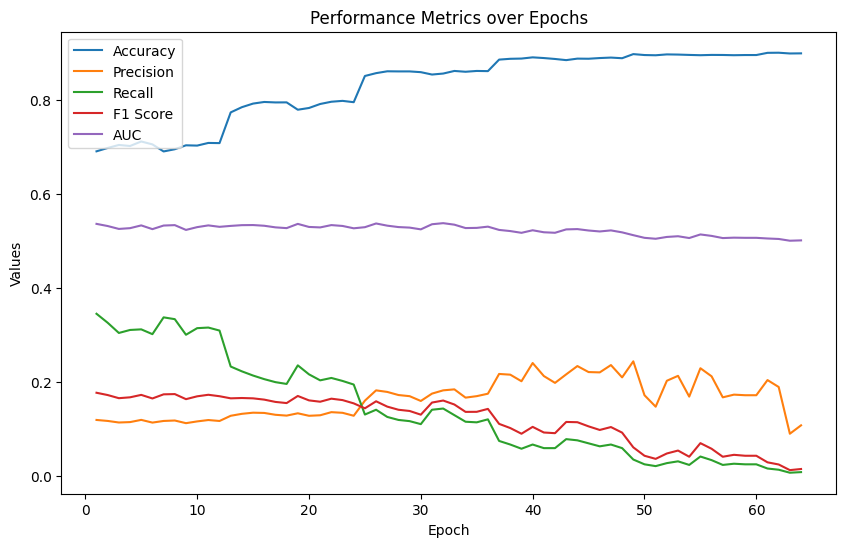

PHQ-9 - 32910 samples: : 5it [30:14, 362.85s/it]


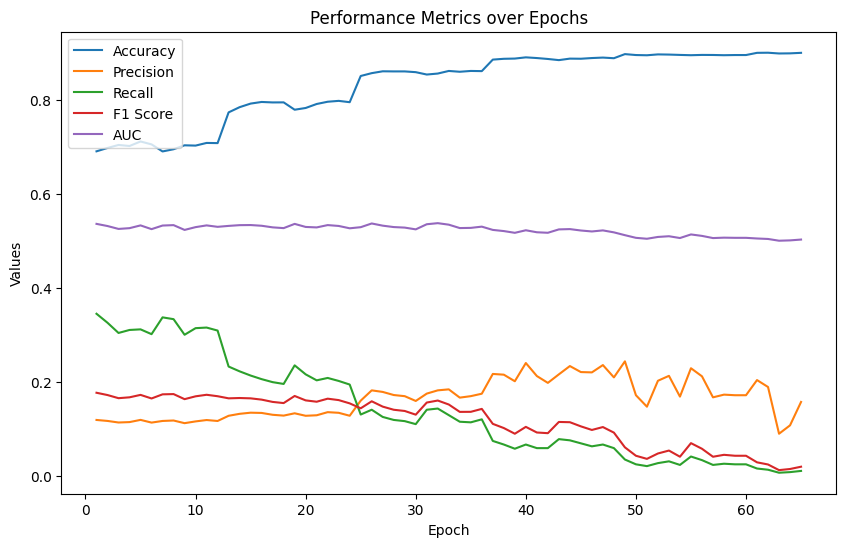

PHQ-9 - 32910 samples: : 5it [55:52, 670.57s/it]


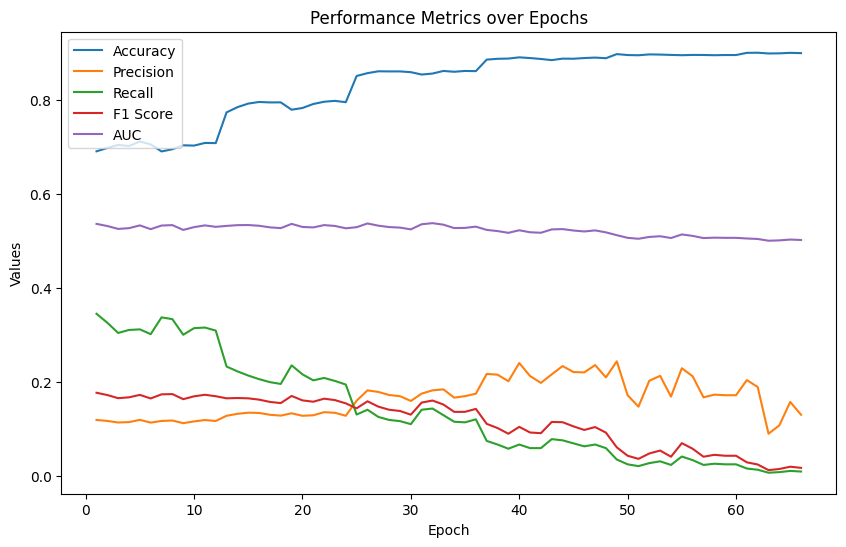

PHQ-9 - 32910 samples: : 3it [05:14, 104.90s/it]

In [31]:
main(X_train,y_train,X_test,y_test)